In [1]:
# importing python modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import read_h5ad
from anndata import read_csv
import anndata
from plotnine import * 
from plotnine.data import mtcars
import venn
from scipy import stats
import seaborn as sns
from scipy.stats import spearmanr
from scipy.sparse import csr_matrix
import math
from scipy.stats import pearsonr

%matplotlib inline
sc.logging.print_header()

scanpy==1.8.1 anndata==0.7.5 umap==0.5.1 numpy==1.21.0 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.2 pynndescent==0.5.2


In [2]:
### dbscan clustering on UMAP embedding


def dbscan_umap(adata, eps=None, min_samples=None):
    """
    Cluster using DBSCAN.
    Parameters
    ----------
    eps : float or None, optional
        The maximum distance between samples for being considered as in the same
        neighborhood. Clusters are "grown" from samples that have more than
        min_samples points in their neighborhood. Increasing eps therefore 
        allows clusters to spread over wider regions.
    min_samples : int or None, optional
        The number of samples (or total weight) in a neighborhood for a point
        to be considered as a core point. This includes the point itself.
    References
    ----------
    Ester et al. (1996), "A Density-Based Algorithm for Discovering Clusters in
    Large Spatial Databases with Noise".
    In: Proceedings of the 2nd International Conference on Knowledge Discovery
    and Data Mining, Portland, OR, AAAI Press, pp. 226-231.
    Pedregosa et al. (2011) ...
    """
    if 'X_umap' in adata.obsm:
        X = adata.obsm['X_umap']
    if eps is None:
        # average area per point
        avg_area_per_point = ((np.max(X[:, 0]) - np.min(X[:, 0]))
                              * (np.max(X[:, 1]) - np.min(X[:, 1])) / X.shape[0])
        eps = 3*np.sqrt(avg_area_per_point)
        # reduce a bit further
        #sett.m(0, '... using eps', eps)
    if min_samples is None:
        min_samples = int(X.shape[0] / 120)
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    mask = labels == -1
    #sett.m(0, 'found', len(np.unique(labels))-1, 'clusters')
    labels = labels.astype(str)
    labels[mask] = '?'
    adata.obs['dbscan_groups'] = labels
    return adata

# barcodes_metadata

In [3]:
multi_barcodes_metadata = pd.read_csv('files/PDX_MULTI-SEQ_Metadata.csv')
multi_barcodes_metadata

,Sample,MULTI,Barcode,PDX_experiment,Tumor,animalID,Tissue,ER,PR,Her2,Intrinsic_BC_subtype,Met_potent,Met_rank,Tumor_size
0,Sample1,Sample1,NaN,PDX1,HCI010,846,tumor,negative,negative,negative,Basal,high,13,2.5
1,Sample2,Sample2,NaN,PDX1,HCI001,892,tumor,negative,negative,negative,Basal,moderate,9,2.5
2,Sample3,Sample3,NaN,PDX1,HCI009,2019,tumor,negative,negative,negative,Luminal B,moderate,7,2.5
3,Sample4,Sample4,NaN,PDX1,H4272,824,tumor,negative,negative,negative,Basal,low,6,2.5
4,Sample5,Sample5,NaN,PDX1,HCI002,828,tumor,negative,negative,negative,Basal,low,1,2.5
5,Sample6,Sample6,NaN,PDX1,HCI010,846,lung,negative,negative,negative,Basal,high,13,2.5
6,Sample7,Sample7,NaN,PDX1,HCI001,892,lung,negative,negative,negative,Basal,moderate,9,2.5
7,Sample8,Sample8,NaN,PDX1,HCI009,2019,lung,negative,negative,negative,Luminal B,moderate,7,2.5
8,Sample9,Sample9,NaN,PDX1,H4272,824,lung,negative,negative,negative,Basal,low,6,2.5
9,Sample10,Sample10,NaN,PDX1,HCI002,828,lung,negative,negative,negative,Basal,low,1,2.5


In [4]:
multi_barcodes_metadata = multi_barcodes_metadata.set_index('MULTI')
multi_barcodes_metadata = multi_barcodes_metadata.append(pd.Series(name='Negative'))
multi_barcodes_metadata = multi_barcodes_metadata.append(pd.Series(name='Doublet'))
for i in multi_barcodes_metadata.columns.tolist():
    multi_barcodes_metadata.loc['Negative', i] = "Negative"
    multi_barcodes_metadata.loc['Doublet', i] = "Doublet"
multi_barcodes_metadata

<ipython-input-4-e67a8256855b>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<ipython-input-4-e67a8256855b>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Sample,Barcode,PDX_experiment,Tumor,animalID,Tissue,ER,PR,Her2,Intrinsic_BC_subtype,Met_potent,Met_rank,Tumor_size
MULTI,,,,,,,,,,,,,
Sample1,Sample1,NaN,PDX1,HCI010,846,tumor,negative,negative,negative,Basal,high,13.0,2.5
Sample2,Sample2,NaN,PDX1,HCI001,892,tumor,negative,negative,negative,Basal,moderate,9.0,2.5
Sample3,Sample3,NaN,PDX1,HCI009,2019,tumor,negative,negative,negative,Luminal B,moderate,7.0,2.5
Sample4,Sample4,NaN,PDX1,H4272,824,tumor,negative,negative,negative,Basal,low,6.0,2.5
Sample5,Sample5,NaN,PDX1,HCI002,828,tumor,negative,negative,negative,Basal,low,1.0,2.5
Sample6,Sample6,NaN,PDX1,HCI010,846,lung,negative,negative,negative,Basal,high,13.0,2.5
Sample7,Sample7,NaN,PDX1,HCI001,892,lung,negative,negative,negative,Basal,moderate,9.0,2.5
Sample8,Sample8,NaN,PDX1,HCI009,2019,lung,negative,negative,negative,Luminal B,moderate,7.0,2.5
Sample9,Sample9,NaN,PDX1,H4272,824,lung,negative,negative,negative,Basal,low,6.0,2.5


In [5]:
multi_result = pd.read_csv('files/MULTIseq_classifications_PDX1_PDX2_PDX3.csv',index_col=0)
multi_result

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGACTAGGC-1,Sample8,Sample8,Sample8,PDX1_A
AAACCTGAGCCACTAT-1,Sample4,Sample4,Sample4,PDX1_A
AAACCTGAGGGTCTCC-1,Doublet,Doublet,Doublet,PDX1_A
AAACCTGCAATCACAC-1,Sample5,Sample5,Sample5,PDX1_A
AAACCTGCACAAGTAA-1,Sample4,Sample4,Sample4,PDX1_A
...,...,...,...,...
TTTGTCATCTACTATC-8,Bar1,Bar1,Bar1,PDX3_B
TTTGTCATCTGCTGCT-8,Bar15,Bar15,Bar15,PDX3_B
TTTGTCATCTGGGCCA-8,Negative,Negative,Bar10,PDX3_B
TTTGTCATCTGTCCGT-8,Bar7,Bar7,Bar7,PDX3_B


# Basic filtering for each individual 10X run

## PDX1A

In [6]:
adata_PDX1A = sc.read_10x_h5('MULTI-seq_cellranger_matrix/PDX1A.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
adata_PDX1A.var_names_make_unique()

In [8]:
adata_PDX1A

AnnData object with n_obs × n_vars = 737280 × 113316
    var: 'gene_ids', 'feature_types', 'genome'

In [9]:
human_genes = [name for name in adata_PDX1A.var_names if name.startswith('human_')]
adata_PDX1A = adata_PDX1A[:,adata_PDX1A.var_names.isin(human_genes)]

In [10]:
adata_PDX1A.obs['run_id'] = 'PDX1A'

Trying to set attribute `.obs` of view, copying.


In [11]:
adata_PDX1A.var.index = [i.split('_')[3] for i in adata_PDX1A.var.index]
adata_PDX1A.var

,gene_ids,feature_types,genome
DDX11L1,human_gencode_v30_ENSG00000223972.5,Gene Expression,human_gencode_v30
WASH7P,human_gencode_v30_ENSG00000227232.5,Gene Expression,human_gencode_v30
MIR6859-1,human_gencode_v30_ENSG00000278267.1,Gene Expression,human_gencode_v30
MIR1302-2HG,human_gencode_v30_ENSG00000243485.5,Gene Expression,human_gencode_v30
MIR1302-2,human_gencode_v30_ENSG00000284332.1,Gene Expression,human_gencode_v30
...,...,...,...
MT-ND6,human_gencode_v30_ENSG00000198695.2,Gene Expression,human_gencode_v30
MT-TE,human_gencode_v30_ENSG00000210194.1,Gene Expression,human_gencode_v30
MT-CYB,human_gencode_v30_ENSG00000198727.2,Gene Expression,human_gencode_v30
MT-TT,human_gencode_v30_ENSG00000210195.2,Gene Expression,human_gencode_v30


In [12]:
sc.pp.filter_cells(adata_PDX1A, min_counts=2500)
sc.pp.filter_cells(adata_PDX1A, min_genes=250)

In [13]:
adata_PDX1A

AnnData object with n_obs × n_vars = 2407 × 58870
    obs: 'run_id', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

In [14]:
mito_genes = adata_PDX1A.var_names.str.startswith('MT-')
adata_PDX1A.obs['percent_mito'] = np.sum(
    adata_PDX1A[:, mito_genes].X, axis=1) / np.sum(adata_PDX1A.X, axis=1) * 100


In [15]:
adata_PDX1A = adata_PDX1A[adata_PDX1A.obs['percent_mito'] <= 50]
adata_PDX1A

View of AnnData object with n_obs × n_vars = 2302 × 58870
    obs: 'run_id', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome'

In [16]:
adata_PDX1A.write_h5ad('for_deconX/PDX1A.h5ad')

/home/weilun/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'run_id' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


## PDX1B

In [17]:
adata_PDX1B = sc.read_10x_h5('MULTI-seq_cellranger_matrix/PDX1B.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [18]:
adata_PDX1B.var_names_make_unique()

In [19]:
adata_PDX1B

AnnData object with n_obs × n_vars = 737280 × 113316
    var: 'gene_ids', 'feature_types', 'genome'

In [20]:
human_genes = [name for name in adata_PDX1B.var_names if name.startswith('human_')]
adata_PDX1B = adata_PDX1B[:,adata_PDX1B.var_names.isin(human_genes)]

In [21]:
adata_PDX1B.obs['run_id'] = 'PDX1B'

Trying to set attribute `.obs` of view, copying.


In [22]:
adata_PDX1B.var.index = [i.split('_')[3] for i in adata_PDX1B.var.index]
adata_PDX1B.var

,gene_ids,feature_types,genome
DDX11L1,human_gencode_v30_ENSG00000223972.5,Gene Expression,human_gencode_v30
WASH7P,human_gencode_v30_ENSG00000227232.5,Gene Expression,human_gencode_v30
MIR6859-1,human_gencode_v30_ENSG00000278267.1,Gene Expression,human_gencode_v30
MIR1302-2HG,human_gencode_v30_ENSG00000243485.5,Gene Expression,human_gencode_v30
MIR1302-2,human_gencode_v30_ENSG00000284332.1,Gene Expression,human_gencode_v30
...,...,...,...
MT-ND6,human_gencode_v30_ENSG00000198695.2,Gene Expression,human_gencode_v30
MT-TE,human_gencode_v30_ENSG00000210194.1,Gene Expression,human_gencode_v30
MT-CYB,human_gencode_v30_ENSG00000198727.2,Gene Expression,human_gencode_v30
MT-TT,human_gencode_v30_ENSG00000210195.2,Gene Expression,human_gencode_v30


In [23]:
sc.pp.filter_cells(adata_PDX1B, min_counts=2500)
sc.pp.filter_cells(adata_PDX1B, min_genes=250)

In [24]:
adata_PDX1B

AnnData object with n_obs × n_vars = 2677 × 58870
    obs: 'run_id', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

In [25]:
mito_genes = adata_PDX1B.var_names.str.startswith('MT-')
adata_PDX1B.obs['percent_mito'] = np.sum(
    adata_PDX1B[:, mito_genes].X, axis=1) / np.sum(adata_PDX1B.X, axis=1) * 100


In [26]:
adata_PDX1B = adata_PDX1B[adata_PDX1B.obs['percent_mito'] <= 50]
adata_PDX1B

View of AnnData object with n_obs × n_vars = 2526 × 58870
    obs: 'run_id', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome'

In [27]:
adata_PDX1B.write_h5ad('for_deconX/PDX1B.h5ad')

/home/weilun/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'run_id' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


## PDX1C

In [28]:
adata_PDX1C = sc.read_10x_h5('MULTI-seq_cellranger_matrix/PDX1C.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [29]:
adata_PDX1C.var_names_make_unique()

In [30]:
adata_PDX1C

AnnData object with n_obs × n_vars = 737280 × 113316
    var: 'gene_ids', 'feature_types', 'genome'

In [31]:
human_genes = [name for name in adata_PDX1C.var_names if name.startswith('human_')]
adata_PDX1C = adata_PDX1C[:,adata_PDX1C.var_names.isin(human_genes)]

In [32]:
adata_PDX1C.obs['run_id'] = 'PDX1C'

Trying to set attribute `.obs` of view, copying.


In [33]:
adata_PDX1C.var.index = [i.split('_')[3] for i in adata_PDX1C.var.index]
adata_PDX1C.var

,gene_ids,feature_types,genome
DDX11L1,human_gencode_v30_ENSG00000223972.5,Gene Expression,human_gencode_v30
WASH7P,human_gencode_v30_ENSG00000227232.5,Gene Expression,human_gencode_v30
MIR6859-1,human_gencode_v30_ENSG00000278267.1,Gene Expression,human_gencode_v30
MIR1302-2HG,human_gencode_v30_ENSG00000243485.5,Gene Expression,human_gencode_v30
MIR1302-2,human_gencode_v30_ENSG00000284332.1,Gene Expression,human_gencode_v30
...,...,...,...
MT-ND6,human_gencode_v30_ENSG00000198695.2,Gene Expression,human_gencode_v30
MT-TE,human_gencode_v30_ENSG00000210194.1,Gene Expression,human_gencode_v30
MT-CYB,human_gencode_v30_ENSG00000198727.2,Gene Expression,human_gencode_v30
MT-TT,human_gencode_v30_ENSG00000210195.2,Gene Expression,human_gencode_v30


In [34]:
sc.pp.filter_cells(adata_PDX1C, min_counts=2500)
sc.pp.filter_cells(adata_PDX1C, min_genes=250)

In [35]:
adata_PDX1C

AnnData object with n_obs × n_vars = 2777 × 58870
    obs: 'run_id', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

In [36]:
mito_genes = adata_PDX1C.var_names.str.startswith('MT-')
adata_PDX1C.obs['percent_mito'] = np.sum(
    adata_PDX1C[:, mito_genes].X, axis=1) / np.sum(adata_PDX1C.X, axis=1) * 100


In [37]:
adata_PDX1C = adata_PDX1C[adata_PDX1C.obs['percent_mito'] <= 50]
adata_PDX1C

View of AnnData object with n_obs × n_vars = 2627 × 58870
    obs: 'run_id', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome'

In [38]:
adata_PDX1C.write_h5ad('for_deconX/PDX1C.h5ad')

/home/weilun/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'run_id' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


## PDX1D

In [39]:
adata_PDX1D = sc.read_10x_h5('MULTI-seq_cellranger_matrix/PDX1D.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [40]:
adata_PDX1D.var_names_make_unique()

In [41]:
adata_PDX1D

AnnData object with n_obs × n_vars = 737280 × 113316
    var: 'gene_ids', 'feature_types', 'genome'

In [42]:
human_genes = [name for name in adata_PDX1D.var_names if name.startswith('human_')]
adata_PDX1D = adata_PDX1D[:,adata_PDX1D.var_names.isin(human_genes)]

In [43]:
adata_PDX1D.obs['run_id'] = 'PDX1D'

Trying to set attribute `.obs` of view, copying.


In [44]:
adata_PDX1D.var.index = [i.split('_')[3] for i in adata_PDX1D.var.index]
adata_PDX1D.var

,gene_ids,feature_types,genome
DDX11L1,human_gencode_v30_ENSG00000223972.5,Gene Expression,human_gencode_v30
WASH7P,human_gencode_v30_ENSG00000227232.5,Gene Expression,human_gencode_v30
MIR6859-1,human_gencode_v30_ENSG00000278267.1,Gene Expression,human_gencode_v30
MIR1302-2HG,human_gencode_v30_ENSG00000243485.5,Gene Expression,human_gencode_v30
MIR1302-2,human_gencode_v30_ENSG00000284332.1,Gene Expression,human_gencode_v30
...,...,...,...
MT-ND6,human_gencode_v30_ENSG00000198695.2,Gene Expression,human_gencode_v30
MT-TE,human_gencode_v30_ENSG00000210194.1,Gene Expression,human_gencode_v30
MT-CYB,human_gencode_v30_ENSG00000198727.2,Gene Expression,human_gencode_v30
MT-TT,human_gencode_v30_ENSG00000210195.2,Gene Expression,human_gencode_v30


In [45]:
sc.pp.filter_cells(adata_PDX1D, min_counts=2500)
sc.pp.filter_cells(adata_PDX1D, min_genes=250)

In [46]:
adata_PDX1D

AnnData object with n_obs × n_vars = 2656 × 58870
    obs: 'run_id', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

In [47]:
mito_genes = adata_PDX1D.var_names.str.startswith('MT-')
adata_PDX1D.obs['percent_mito'] = np.sum(
    adata_PDX1D[:, mito_genes].X, axis=1) / np.sum(adata_PDX1D.X, axis=1) * 100


In [48]:
adata_PDX1D = adata_PDX1D[adata_PDX1D.obs['percent_mito'] <= 50]
adata_PDX1D

View of AnnData object with n_obs × n_vars = 2476 × 58870
    obs: 'run_id', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome'

In [49]:
adata_PDX1D.write_h5ad('for_deconX/PDX1D.h5ad')

/home/weilun/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'run_id' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


## PDX2LT

In [50]:
adata_PDX2LT = sc.read_10x_h5('MULTI-seq_cellranger_matrix/PDX2LT.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [51]:
adata_PDX2LT.var_names_make_unique()

In [52]:
adata_PDX2LT

AnnData object with n_obs × n_vars = 737280 × 113316
    var: 'gene_ids', 'feature_types', 'genome'

In [53]:
human_genes = [name for name in adata_PDX2LT.var_names if name.startswith('human_')]
adata_PDX2LT = adata_PDX2LT[:,adata_PDX2LT.var_names.isin(human_genes)]

In [54]:
adata_PDX2LT.obs['run_id'] = 'PDX2LT'

Trying to set attribute `.obs` of view, copying.


In [55]:
adata_PDX2LT.var.index = [i.split('_')[3] for i in adata_PDX2LT.var.index]
adata_PDX2LT.var

,gene_ids,feature_types,genome
DDX11L1,human_gencode_v30_ENSG00000223972.5,Gene Expression,human_gencode_v30
WASH7P,human_gencode_v30_ENSG00000227232.5,Gene Expression,human_gencode_v30
MIR6859-1,human_gencode_v30_ENSG00000278267.1,Gene Expression,human_gencode_v30
MIR1302-2HG,human_gencode_v30_ENSG00000243485.5,Gene Expression,human_gencode_v30
MIR1302-2,human_gencode_v30_ENSG00000284332.1,Gene Expression,human_gencode_v30
...,...,...,...
MT-ND6,human_gencode_v30_ENSG00000198695.2,Gene Expression,human_gencode_v30
MT-TE,human_gencode_v30_ENSG00000210194.1,Gene Expression,human_gencode_v30
MT-CYB,human_gencode_v30_ENSG00000198727.2,Gene Expression,human_gencode_v30
MT-TT,human_gencode_v30_ENSG00000210195.2,Gene Expression,human_gencode_v30


In [56]:
sc.pp.filter_cells(adata_PDX2LT, min_counts=2500)
sc.pp.filter_cells(adata_PDX2LT, min_genes=250)

In [57]:
adata_PDX2LT

AnnData object with n_obs × n_vars = 10096 × 58870
    obs: 'run_id', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

In [58]:
mito_genes = adata_PDX2LT.var_names.str.startswith('MT-')
adata_PDX2LT.obs['percent_mito'] = np.sum(
    adata_PDX2LT[:, mito_genes].X, axis=1) / np.sum(adata_PDX2LT.X, axis=1) * 100


In [59]:
adata_PDX2LT = adata_PDX2LT[adata_PDX2LT.obs['percent_mito'] <= 50]
adata_PDX2LT

View of AnnData object with n_obs × n_vars = 10096 × 58870
    obs: 'run_id', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome'

In [60]:
adata_PDX2LT.write_h5ad('for_deconX/PDX2LT.h5ad')

/home/weilun/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'run_id' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


## PDX2POOL

In [61]:
adata_PDX2POOL = sc.read_10x_h5('MULTI-seq_cellranger_matrix/PDX2POOL.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [62]:
adata_PDX2POOL.var_names_make_unique()

In [63]:
adata_PDX2POOL

AnnData object with n_obs × n_vars = 737280 × 113316
    var: 'gene_ids', 'feature_types', 'genome'

In [64]:
human_genes = [name for name in adata_PDX2POOL.var_names if name.startswith('human_')]
adata_PDX2POOL = adata_PDX2POOL[:,adata_PDX2POOL.var_names.isin(human_genes)]

In [65]:
adata_PDX2POOL.obs['run_id'] = 'PDX2POOL'

Trying to set attribute `.obs` of view, copying.


In [66]:
adata_PDX2POOL.var.index = [i.split('_')[3] for i in adata_PDX2POOL.var.index]
adata_PDX2POOL.var

,gene_ids,feature_types,genome
DDX11L1,human_gencode_v30_ENSG00000223972.5,Gene Expression,human_gencode_v30
WASH7P,human_gencode_v30_ENSG00000227232.5,Gene Expression,human_gencode_v30
MIR6859-1,human_gencode_v30_ENSG00000278267.1,Gene Expression,human_gencode_v30
MIR1302-2HG,human_gencode_v30_ENSG00000243485.5,Gene Expression,human_gencode_v30
MIR1302-2,human_gencode_v30_ENSG00000284332.1,Gene Expression,human_gencode_v30
...,...,...,...
MT-ND6,human_gencode_v30_ENSG00000198695.2,Gene Expression,human_gencode_v30
MT-TE,human_gencode_v30_ENSG00000210194.1,Gene Expression,human_gencode_v30
MT-CYB,human_gencode_v30_ENSG00000198727.2,Gene Expression,human_gencode_v30
MT-TT,human_gencode_v30_ENSG00000210195.2,Gene Expression,human_gencode_v30


In [67]:
sc.pp.filter_cells(adata_PDX2POOL, min_counts=2500)
sc.pp.filter_cells(adata_PDX2POOL, min_genes=250)

In [68]:
adata_PDX2POOL

AnnData object with n_obs × n_vars = 140 × 58870
    obs: 'run_id', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

In [69]:
mito_genes = adata_PDX2POOL.var_names.str.startswith('MT-')
adata_PDX2POOL.obs['percent_mito'] = np.sum(
    adata_PDX2POOL[:, mito_genes].X, axis=1) / np.sum(adata_PDX2POOL.X, axis=1) * 100


In [70]:
adata_PDX2POOL = adata_PDX2POOL[adata_PDX2POOL.obs['percent_mito'] <= 50]
adata_PDX2POOL

View of AnnData object with n_obs × n_vars = 140 × 58870
    obs: 'run_id', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome'

In [71]:
adata_PDX2POOL.write_h5ad('for_deconX/PDX2POOL.h5ad')

/home/weilun/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'run_id' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


## PDX3A

In [72]:
adata_PDX3A = sc.read_10x_h5('MULTI-seq_cellranger_matrix/PDX3A.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [73]:
adata_PDX3A.var_names_make_unique()

In [74]:
adata_PDX3A

AnnData object with n_obs × n_vars = 737280 × 113316
    var: 'gene_ids', 'feature_types', 'genome'

In [75]:
human_genes = [name for name in adata_PDX3A.var_names if name.startswith('human_')]
adata_PDX3A = adata_PDX3A[:,adata_PDX3A.var_names.isin(human_genes)]

In [76]:
adata_PDX3A.obs['run_id'] = 'PDX3A'

Trying to set attribute `.obs` of view, copying.


In [77]:
adata_PDX3A.var.index = [i.split('_')[3] for i in adata_PDX3A.var.index]
adata_PDX3A.var

,gene_ids,feature_types,genome
DDX11L1,human_gencode_v30_ENSG00000223972.5,Gene Expression,human_gencode_v30
WASH7P,human_gencode_v30_ENSG00000227232.5,Gene Expression,human_gencode_v30
MIR6859-1,human_gencode_v30_ENSG00000278267.1,Gene Expression,human_gencode_v30
MIR1302-2HG,human_gencode_v30_ENSG00000243485.5,Gene Expression,human_gencode_v30
MIR1302-2,human_gencode_v30_ENSG00000284332.1,Gene Expression,human_gencode_v30
...,...,...,...
MT-ND6,human_gencode_v30_ENSG00000198695.2,Gene Expression,human_gencode_v30
MT-TE,human_gencode_v30_ENSG00000210194.1,Gene Expression,human_gencode_v30
MT-CYB,human_gencode_v30_ENSG00000198727.2,Gene Expression,human_gencode_v30
MT-TT,human_gencode_v30_ENSG00000210195.2,Gene Expression,human_gencode_v30


In [78]:
sc.pp.filter_cells(adata_PDX3A, min_counts=2500)
sc.pp.filter_cells(adata_PDX3A, min_genes=250)

In [79]:
adata_PDX3A

AnnData object with n_obs × n_vars = 5572 × 58870
    obs: 'run_id', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

In [80]:
mito_genes = adata_PDX3A.var_names.str.startswith('MT-')
adata_PDX3A.obs['percent_mito'] = np.sum(
    adata_PDX3A[:, mito_genes].X, axis=1) / np.sum(adata_PDX3A.X, axis=1) * 100


In [81]:
adata_PDX3A = adata_PDX3A[adata_PDX3A.obs['percent_mito'] <= 50]
adata_PDX3A

View of AnnData object with n_obs × n_vars = 5271 × 58870
    obs: 'run_id', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome'

In [82]:
adata_PDX3A.write_h5ad('for_deconX/PDX3A.h5ad')

/home/weilun/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'run_id' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


## PDX3B

In [83]:
adata_PDX3B = sc.read_10x_h5('MULTI-seq_cellranger_matrix/PDX3B.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [84]:
adata_PDX3B.var_names_make_unique()

In [85]:
adata_PDX3B

AnnData object with n_obs × n_vars = 737280 × 113316
    var: 'gene_ids', 'feature_types', 'genome'

In [86]:
human_genes = [name for name in adata_PDX3B.var_names if name.startswith('human_')]
adata_PDX3B = adata_PDX3B[:,adata_PDX3B.var_names.isin(human_genes)]

In [87]:
adata_PDX3B.obs['run_id'] = 'PDX3B'

Trying to set attribute `.obs` of view, copying.


In [88]:
adata_PDX3B.var.index = [i.split('_')[3] for i in adata_PDX3B.var.index]
adata_PDX3B.var

,gene_ids,feature_types,genome
DDX11L1,human_gencode_v30_ENSG00000223972.5,Gene Expression,human_gencode_v30
WASH7P,human_gencode_v30_ENSG00000227232.5,Gene Expression,human_gencode_v30
MIR6859-1,human_gencode_v30_ENSG00000278267.1,Gene Expression,human_gencode_v30
MIR1302-2HG,human_gencode_v30_ENSG00000243485.5,Gene Expression,human_gencode_v30
MIR1302-2,human_gencode_v30_ENSG00000284332.1,Gene Expression,human_gencode_v30
...,...,...,...
MT-ND6,human_gencode_v30_ENSG00000198695.2,Gene Expression,human_gencode_v30
MT-TE,human_gencode_v30_ENSG00000210194.1,Gene Expression,human_gencode_v30
MT-CYB,human_gencode_v30_ENSG00000198727.2,Gene Expression,human_gencode_v30
MT-TT,human_gencode_v30_ENSG00000210195.2,Gene Expression,human_gencode_v30


In [89]:
sc.pp.filter_cells(adata_PDX3B, min_counts=2500)
sc.pp.filter_cells(adata_PDX3B, min_genes=250)

In [90]:
adata_PDX3B

AnnData object with n_obs × n_vars = 5519 × 58870
    obs: 'run_id', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'

In [91]:
mito_genes = adata_PDX3B.var_names.str.startswith('MT-')
adata_PDX3B.obs['percent_mito'] = np.sum(
    adata_PDX3B[:, mito_genes].X, axis=1) / np.sum(adata_PDX3B.X, axis=1) * 100


In [92]:
adata_PDX3B = adata_PDX3B[adata_PDX3B.obs['percent_mito'] <= 50]
adata_PDX3B

View of AnnData object with n_obs × n_vars = 5324 × 58870
    obs: 'run_id', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome'

In [93]:
adata_PDX3B.write_h5ad('for_deconX/PDX3B.h5ad')

/home/weilun/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'run_id' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


# writing bash for dectonX

In [96]:
bash_file = open("MULTI-seq_decontX.sh", "w")
for sample_batch in ['PDX1A', 'PDX1B', 'PDX1C', 'PDX1D', 'PDX2LT', 'PDX2POOL', 'PDX3A', 'PDX3B']:
    bash_file.write('Rscript decontX_processing.R for_deconX/' + sample_batch + '.h5ad for_deconX/' + sample_batch + '.h5seurat ' + sample_batch)
    bash_file.write("\n")

In [97]:
"""
  using MULTI-seq_decontX.sh to run dectonX
  
"""

'\n  using MULTI-seq_decontX.sh to run dectonX\n  \n'

# after decontX

In [98]:
cell_cycle_genes = [x.strip() for x in open('files/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

## PDX1A

In [99]:
adata_PDX1A_decontX = sc.read_csv('decontx_counts_output/decontX_PDX1A.csv')

In [100]:
adata_PDX1A_decontX = adata_PDX1A_decontX.T

In [101]:
adata_PDX1A_decontX

AnnData object with n_obs × n_vars = 2302 × 58870

In [102]:
sc.pp.filter_cells(adata_PDX1A_decontX, min_counts=0)
sc.pp.filter_cells(adata_PDX1A_decontX, min_genes=0)

In [103]:
mito_genes = adata_PDX1A_decontX.var_names.str.startswith('MT-')
adata_PDX1A_decontX.obs['percent_mito'] = np.sum(
    adata_PDX1A_decontX[:, mito_genes].X, axis=1) / np.sum(adata_PDX1A_decontX.X, axis=1) * 100


In [104]:
adata_PDX1A_decontX

AnnData object with n_obs × n_vars = 2302 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito'

In [105]:
temp_df = multi_result[multi_result['experiment'] == "PDX1_A"]
temp_df.index = [i.split('-')[0] + '-1' for i in temp_df.index]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGACTAGGC-1,Sample8,Sample8,Sample8,PDX1_A
AAACCTGAGCCACTAT-1,Sample4,Sample4,Sample4,PDX1_A
AAACCTGAGGGTCTCC-1,Doublet,Doublet,Doublet,PDX1_A
AAACCTGCAATCACAC-1,Sample5,Sample5,Sample5,PDX1_A
AAACCTGCACAAGTAA-1,Sample4,Sample4,Sample4,PDX1_A
...,...,...,...,...
TTTGTCAGTGGTTTCA-1,Sample5,Sample5,Sample5,PDX1_A
TTTGTCATCAAACCAC-1,Sample7,Sample7,Sample7,PDX1_A
TTTGTCATCAGTTCGA-1,Negative,Negative,Sample2,PDX1_A
TTTGTCATCCGCGGTA-1,Sample2,Sample2,Sample2,PDX1_A


In [106]:
adata_PDX1A_decontX.obs.index = [i.split('.')[0]+'-1' for i in adata_PDX1A_decontX.obs.index]
adata_PDX1A_decontX.obs

,n_counts,n_genes,percent_mito
AAACCTGAGCCACTAT-1,3084.044678,1204,28.874271
AAACCTGTCCTTTCGG-1,8261.315430,3054,3.121930
AAACCTGTCTTTACAC-1,5622.913086,2297,3.691891
AAACGGGCACCACGTG-1,4079.357910,1175,26.499096
AAACGGGCACCTCGTT-1,3337.482910,1231,14.729706
...,...,...,...
TTTGCGCGTGTAACGG-1,2591.362061,1071,27.225737
TTTGCGCGTTGGTGGA-1,16016.660156,3359,10.406938
TTTGCGCTCTGCTTGC-1,24112.775391,5006,8.102990
TTTGGTTGTCAAGCGA-1,8348.500977,2658,4.073095


In [107]:
temp_df = temp_df[temp_df.index.isin(adata_PDX1A_decontX.obs.index.tolist())]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGCCACTAT-1,Sample4,Sample4,Sample4,PDX1_A
AAACCTGTCCTTTCGG-1,Sample2,Sample2,Sample2,PDX1_A
AAACCTGTCTTTACAC-1,Sample4,Sample4,Sample4,PDX1_A
AAACGGGCACCACGTG-1,Sample4,Sample4,Sample4,PDX1_A
AAACGGGCACCTCGTT-1,Sample2,Sample2,Sample2,PDX1_A
...,...,...,...,...
TTTGCGCGTGTAACGG-1,Sample4,Sample4,Sample4,PDX1_A
TTTGCGCGTTGGTGGA-1,Sample2,Sample2,Sample2,PDX1_A
TTTGCGCTCTGCTTGC-1,Sample2,Sample2,Sample2,PDX1_A
TTTGGTTGTCAAGCGA-1,Sample4,Sample4,Sample4,PDX1_A


In [108]:
temp_df = temp_df[temp_df.index.isin(adata_PDX1A_decontX.obs.index.tolist())]
adata_PDX1A_decontX.obs['multi_barcode'] = "Negative"
for i in temp_df.index:
    adata_PDX1A_decontX.obs.loc[i, 'multi_barcode'] = temp_df.loc[i, 'MULTI']

In [109]:
myList = list(set(adata_PDX1A_decontX.obs['multi_barcode']))

auxdict = dict(multi_barcodes_metadata['Tumor'][myList])
adata_PDX1A_decontX.obs['Tumor_ID'] = adata_PDX1A_decontX.obs['multi_barcode'].map(auxdict)
auxdict = dict(multi_barcodes_metadata['Tissue'][myList])
adata_PDX1A_decontX.obs['sort'] = adata_PDX1A_decontX.obs['multi_barcode'].map(auxdict)

In [110]:
adata_PDX1A_decontX.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort
AAACCTGAGCCACTAT-1,3084.044678,1204,28.874271,Sample4,H4272,tumor
AAACCTGTCCTTTCGG-1,8261.315430,3054,3.121930,Sample2,HCI001,tumor
AAACCTGTCTTTACAC-1,5622.913086,2297,3.691891,Sample4,H4272,tumor
AAACGGGCACCACGTG-1,4079.357910,1175,26.499096,Sample4,H4272,tumor
AAACGGGCACCTCGTT-1,3337.482910,1231,14.729706,Sample2,HCI001,tumor
...,...,...,...,...,...,...
TTTGCGCGTGTAACGG-1,2591.362061,1071,27.225737,Sample4,H4272,tumor
TTTGCGCGTTGGTGGA-1,16016.660156,3359,10.406938,Sample2,HCI001,tumor
TTTGCGCTCTGCTTGC-1,24112.775391,5006,8.102990,Sample2,HCI001,tumor
TTTGGTTGTCAAGCGA-1,8348.500977,2658,4.073095,Sample4,H4272,tumor


## embedding

In [111]:
adata_PDX1A_decontX_process = adata_PDX1A_decontX.copy()

In [112]:
adata_PDX1A_decontX_process

AnnData object with n_obs × n_vars = 2302 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [113]:
adata_PDX1A_decontX_process = adata_PDX1A_decontX_process[~adata_PDX1A_decontX_process.obs['multi_barcode'].isin(['Doublet'])]
sc.pp.filter_cells(adata_PDX1A_decontX_process, min_counts=2500)
sc.pp.filter_cells(adata_PDX1A_decontX_process, min_genes=250)
adata_PDX1A_decontX_process = adata_PDX1A_decontX_process[adata_PDX1A_decontX_process.obs['percent_mito'] <= 50]
adata_PDX1A_decontX_process

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 1822 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [114]:
sc.pp.filter_genes(adata_PDX1A_decontX_process, min_cells=20)
sc.pp.highly_variable_genes(adata_PDX1A_decontX_process, n_top_genes=2000,flavor='seurat_v3')
sc.pp.normalize_per_cell(adata_PDX1A_decontX_process, counts_per_cell_after=1e4)
sc.pp.log1p(adata_PDX1A_decontX_process)

Trying to set attribute `.var` of view, copying.
/home/weilun/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.


In [115]:
adata_PDX1A_decontX_process

AnnData object with n_obs × n_vars = 1822 × 13805
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [116]:
adata_PDX1A_decontX_process.raw = adata_PDX1A_decontX_process
sc.tl.score_genes_cell_cycle(adata_PDX1A_decontX_process, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata_PDX1A_decontX_process, ['S_score', 'G2M_score'])
sc.pp.scale(adata_PDX1A_decontX_process,max_value=10)

... storing 'multi_barcode' as categorical
... storing 'Tumor_ID' as categorical
... storing 'sort' as categorical
... storing 'phase' as categorical


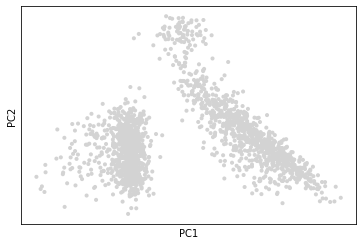

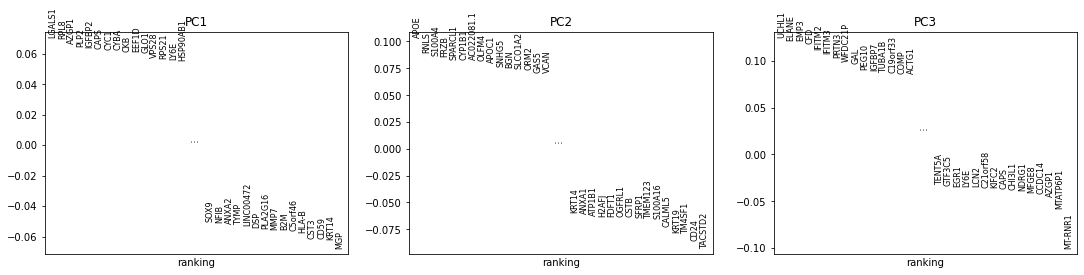

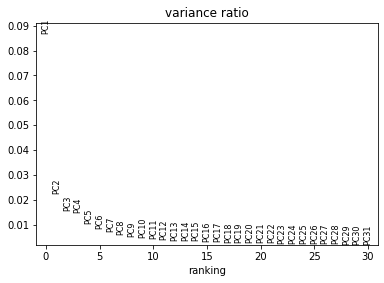

In [117]:
sc.tl.pca(adata_PDX1A_decontX_process, svd_solver='auto')
sc.pl.pca_overview(adata_PDX1A_decontX_process)

In [118]:
sc.pp.neighbors(adata_PDX1A_decontX_process, n_neighbors=15, n_pcs=15)
sc.tl.umap(adata_PDX1A_decontX_process)

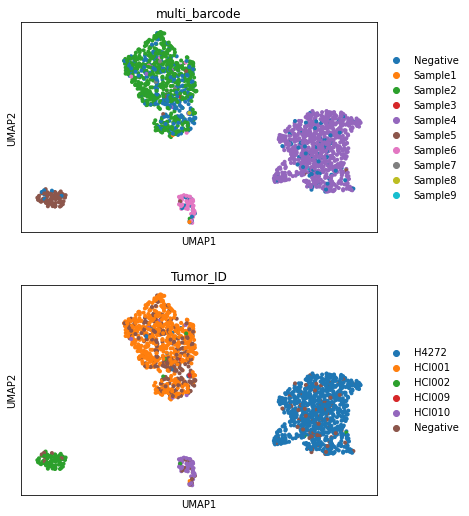

In [119]:
sc.pl.umap(adata_PDX1A_decontX_process, color=['multi_barcode','Tumor_ID'],ncols=1)

... storing 'dbscan_groups' as categorical


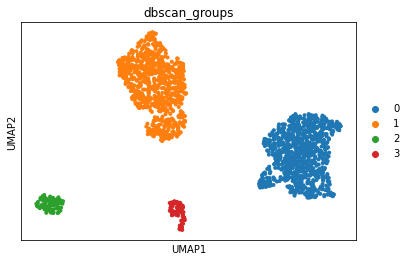

In [120]:
dbscan_umap(adata_PDX1A_decontX_process)
sc.pl.umap(adata_PDX1A_decontX_process, color=['dbscan_groups'],ncols=1)

In [121]:
adata_PDX1A_decontX_process.obs.groupby(['dbscan_groups','Tumor_ID']).apply(len)

dbscan_groups  Tumor_ID
0              H4272       809
               HCI002        2
               HCI010        2
               Negative     72
1              H4272         7
               HCI001      562
               HCI002        4
               HCI009        2
               HCI010        6
               Negative    198
2              HCI002       79
               Negative      8
3              HCI001        1
               HCI002        1
               HCI010       50
               Negative     19
dtype: int64

## Assignment

In [122]:
adata_PDX1A_decontX_process_final = adata_PDX1A_decontX_process.copy()

In [123]:
adata_PDX1A_decontX_process_final

AnnData object with n_obs × n_vars = 1822 × 13805
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'dbscan_groups_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [124]:
adata_PDX1A_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID','sort']).apply(len)

multi_barcode  Tumor_ID  sort    
Negative       Negative  Negative    297
Sample1        HCI010    tumor         3
Sample2        HCI001    tumor       557
Sample3        HCI009    tumor         1
Sample4        H4272     tumor       815
Sample5        HCI002    tumor        86
Sample6        HCI010    lung         55
Sample7        HCI001    lung          6
Sample8        HCI009    lung          1
Sample9        H4272     lung          1
dtype: int64

In [125]:
adata_PDX1A_decontX_process_final.obs['Tumor_ID_updated'] = ""
for i in set(adata_PDX1A_decontX_process_final.obs['dbscan_groups']):
    temp_sub_adata = adata_PDX1A_decontX_process_final[adata_PDX1A_decontX_process_final.obs['dbscan_groups'] == i]
    temp_df = temp_sub_adata.obs.groupby(['Tumor_ID']).apply(len).to_frame()
    temp_df = temp_df.reset_index()
    temp_df = temp_df.set_index('Tumor_ID')
    adata_PDX1A_decontX_process_final.obs.loc[adata_PDX1A_decontX_process_final.obs['dbscan_groups'] == i, 'Tumor_ID_updated'] = temp_df[0].idxmax()

adata_PDX1A_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID_updated','sort']).apply(len)

multi_barcode  Tumor_ID_updated  sort    
Negative       H4272             Negative     72
               HCI001            Negative    198
               HCI002            Negative      8
               HCI010            Negative     19
Sample1        H4272             tumor         1
               HCI001            tumor         1
               HCI010            tumor         1
Sample2        HCI001            tumor       556
               HCI010            tumor         1
Sample3        HCI001            tumor         1
Sample4        H4272             tumor       808
               HCI001            tumor         7
Sample5        H4272             tumor         2
               HCI001            tumor         4
               HCI002            tumor        79
               HCI010            tumor         1
Sample6        H4272             lung          1
               HCI001            lung          5
               HCI010            lung         49
Sample7        HCI001      

... storing 'Tumor_ID_updated' as categorical


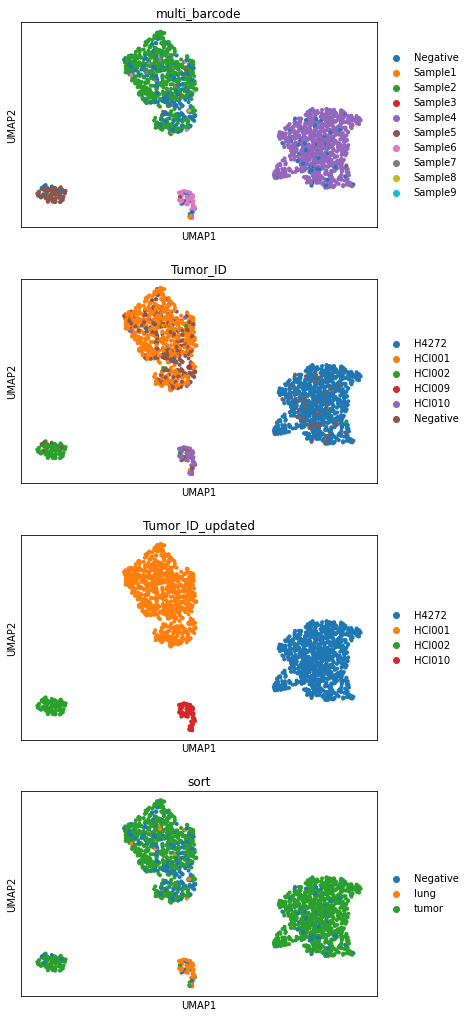

In [126]:
sc.pl.umap(adata_PDX1A_decontX_process_final, color=['multi_barcode','Tumor_ID','Tumor_ID_updated','sort'],ncols=1)

In [127]:
adata_PDX1A_decontX_final_selected = adata_PDX1A_decontX[adata_PDX1A_decontX.obs.index.isin(adata_PDX1A_decontX_process_final.obs.index.tolist())].copy()
adata_PDX1A_decontX_final_selected

AnnData object with n_obs × n_vars = 1822 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [128]:
adata_PDX1A_decontX_process_final

AnnData object with n_obs × n_vars = 1822 × 13805
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups', 'Tumor_ID_updated'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'dbscan_groups_colors', 'Tumor_ID_updated_colors', 'sort_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [129]:
adata_PDX1A_decontX_final_selected.obs['n_counts'] = adata_PDX1A_decontX_process_final.obs['n_counts']
adata_PDX1A_decontX_final_selected.obs['n_genes'] = adata_PDX1A_decontX_process_final.obs['n_genes']
adata_PDX1A_decontX_final_selected.obs['percent_mito'] = adata_PDX1A_decontX_process_final.obs['percent_mito']
adata_PDX1A_decontX_final_selected.obs['multi_barcode'] = adata_PDX1A_decontX_process_final.obs['multi_barcode']
adata_PDX1A_decontX_final_selected.obs['Tumor_ID'] = adata_PDX1A_decontX_process_final.obs['Tumor_ID']
adata_PDX1A_decontX_final_selected.obs['Tumor_ID_updated'] = adata_PDX1A_decontX_process_final.obs['Tumor_ID_updated']
adata_PDX1A_decontX_final_selected.obs['run_id'] = 'PDX1A'
adata_PDX1A_decontX_final_selected.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort,Tumor_ID_updated,run_id
AAACCTGAGCCACTAT-1,3061.061523,1204,28.874271,Sample4,H4272,tumor,H4272,PDX1A
AAACCTGTCCTTTCGG-1,8241.106445,3054,3.121930,Sample2,HCI001,tumor,HCI001,PDX1A
AAACCTGTCTTTACAC-1,5599.453613,2297,3.691891,Sample4,H4272,tumor,H4272,PDX1A
AAACGGGCACCACGTG-1,4058.026367,1175,26.499096,Sample4,H4272,tumor,H4272,PDX1A
AAACGGGCACCTCGTT-1,3332.828613,1231,14.729706,Sample2,HCI001,tumor,HCI001,PDX1A
...,...,...,...,...,...,...,...,...
TTTGCGCGTGTAACGG-1,2580.268066,1071,27.225737,Sample4,H4272,tumor,H4272,PDX1A
TTTGCGCGTTGGTGGA-1,15986.297852,3359,10.406938,Sample2,HCI001,tumor,HCI001,PDX1A
TTTGCGCTCTGCTTGC-1,24034.980469,5006,8.102990,Sample2,HCI001,tumor,HCI001,PDX1A
TTTGGTTGTCAAGCGA-1,8333.292969,2658,4.073095,Sample4,H4272,tumor,H4272,PDX1A


## PDX1B

In [130]:
adata_PDX1B_decontX = sc.read_csv('decontx_counts_output/decontX_PDX1B.csv')

In [131]:
adata_PDX1B_decontX = adata_PDX1B_decontX.T

In [132]:
adata_PDX1B_decontX

AnnData object with n_obs × n_vars = 2526 × 58870

In [133]:
sc.pp.filter_cells(adata_PDX1B_decontX, min_counts=0)
sc.pp.filter_cells(adata_PDX1B_decontX, min_genes=0)

In [134]:
mito_genes = adata_PDX1B_decontX.var_names.str.startswith('MT-')
adata_PDX1B_decontX.obs['percent_mito'] = np.sum(
    adata_PDX1B_decontX[:, mito_genes].X, axis=1) / np.sum(adata_PDX1B_decontX.X, axis=1) * 100


In [135]:
adata_PDX1B_decontX

AnnData object with n_obs × n_vars = 2526 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito'

In [136]:
temp_df = multi_result[multi_result['experiment'] == "PDX1_B"]
temp_df.index = [i.split('-')[0] + '-1' for i in temp_df.index]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGAATTGTG-1,Doublet,Doublet,Doublet,PDX1_B
AAACCTGAGCAAATCA-1,Sample8,Sample8,Sample8,PDX1_B
AAACCTGAGCCTTGAT-1,Sample7,Sample7,Sample7,PDX1_B
AAACCTGAGCTGAACG-1,Doublet,Doublet,Doublet,PDX1_B
AAACCTGAGGGATCTG-1,Sample7,Sample7,Sample7,PDX1_B
...,...,...,...,...
TTTGTCAGTGTCGCTG-1,Sample4,Sample4,Sample4,PDX1_B
TTTGTCAGTTCGAATC-1,Sample2,Sample2,Sample2,PDX1_B
TTTGTCATCACGCATA-1,Negative,Negative,Negative,PDX1_B
TTTGTCATCCGAACGC-1,Sample4,Sample4,Sample4,PDX1_B


In [137]:
adata_PDX1B_decontX.obs.index = [i.split('.')[0]+'-1' for i in adata_PDX1B_decontX.obs.index]
adata_PDX1B_decontX.obs

,n_counts,n_genes,percent_mito
AAACCTGAGCTGAACG-1,6980.366699,2495,26.368225
AAACCTGAGTTACGGG-1,19433.025391,3852,14.342125
AAACCTGCAAGCCATT-1,11251.400391,4323,8.705716
AAACCTGCAAGCTGGA-1,5761.516113,1784,12.593571
AAACCTGGTAGGAGTC-1,3038.371338,926,41.893028
...,...,...,...
TTTGTCAGTACATGTC-1,7646.282227,2714,15.206207
TTTGTCAGTGTCGCTG-1,3876.096191,1245,48.167645
TTTGTCAGTTCGAATC-1,6956.536133,2479,2.972870
TTTGTCATCCGAACGC-1,5633.837402,2573,9.199254


In [138]:
temp_df = temp_df[temp_df.index.isin(adata_PDX1B_decontX.obs.index.tolist())]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGCTGAACG-1,Doublet,Doublet,Doublet,PDX1_B
AAACCTGAGTTACGGG-1,Sample4,Sample4,Sample4,PDX1_B
AAACCTGCAAGCCATT-1,Sample4,Sample4,Sample4,PDX1_B
AAACCTGCAAGCTGGA-1,Sample2,Sample2,Sample2,PDX1_B
AAACCTGGTAGGAGTC-1,Sample4,Sample4,Sample4,PDX1_B
...,...,...,...,...
TTTGTCAGTACATGTC-1,Sample2,Sample2,Sample2,PDX1_B
TTTGTCAGTGTCGCTG-1,Sample4,Sample4,Sample4,PDX1_B
TTTGTCAGTTCGAATC-1,Sample2,Sample2,Sample2,PDX1_B
TTTGTCATCCGAACGC-1,Sample4,Sample4,Sample4,PDX1_B


In [139]:
adata_PDX1B_decontX.obs['multi_barcode'] = "Negative"
for i in temp_df.index:
    adata_PDX1B_decontX.obs.loc[i, 'multi_barcode'] = temp_df.loc[i, 'MULTI']

In [140]:
myList = list(set(adata_PDX1B_decontX.obs['multi_barcode']))

auxdict = dict(multi_barcodes_metadata['Tumor'][myList])
adata_PDX1B_decontX.obs['Tumor_ID'] = adata_PDX1B_decontX.obs['multi_barcode'].map(auxdict)
auxdict = dict(multi_barcodes_metadata['Tissue'][myList])
adata_PDX1B_decontX.obs['sort'] = adata_PDX1B_decontX.obs['multi_barcode'].map(auxdict)

In [141]:
adata_PDX1B_decontX.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort
AAACCTGAGCTGAACG-1,6980.366699,2495,26.368225,Doublet,Doublet,Doublet
AAACCTGAGTTACGGG-1,19433.025391,3852,14.342125,Sample4,H4272,tumor
AAACCTGCAAGCCATT-1,11251.400391,4323,8.705716,Sample4,H4272,tumor
AAACCTGCAAGCTGGA-1,5761.516113,1784,12.593571,Sample2,HCI001,tumor
AAACCTGGTAGGAGTC-1,3038.371338,926,41.893028,Sample4,H4272,tumor
...,...,...,...,...,...,...
TTTGTCAGTACATGTC-1,7646.282227,2714,15.206207,Sample2,HCI001,tumor
TTTGTCAGTGTCGCTG-1,3876.096191,1245,48.167645,Sample4,H4272,tumor
TTTGTCAGTTCGAATC-1,6956.536133,2479,2.972870,Sample2,HCI001,tumor
TTTGTCATCCGAACGC-1,5633.837402,2573,9.199254,Sample4,H4272,tumor


## embedding

In [142]:
adata_PDX1B_decontX_process = adata_PDX1B_decontX.copy()

In [143]:
adata_PDX1B_decontX_process

AnnData object with n_obs × n_vars = 2526 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [144]:
adata_PDX1B_decontX_process = adata_PDX1B_decontX_process[~adata_PDX1B_decontX_process.obs['multi_barcode'].isin(['Doublet'])]
sc.pp.filter_cells(adata_PDX1B_decontX_process, min_counts=2500)
sc.pp.filter_cells(adata_PDX1B_decontX_process, min_genes=250)
adata_PDX1B_decontX_process = adata_PDX1B_decontX_process[adata_PDX1B_decontX_process.obs['percent_mito'] <= 50]
adata_PDX1B_decontX_process

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 1990 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [145]:
sc.pp.filter_genes(adata_PDX1B_decontX_process, min_cells=20)
sc.pp.highly_variable_genes(adata_PDX1B_decontX_process, n_top_genes=2000,flavor='seurat_v3')
sc.pp.normalize_per_cell(adata_PDX1B_decontX_process, counts_per_cell_after=1e4)
sc.pp.log1p(adata_PDX1B_decontX_process)

Trying to set attribute `.var` of view, copying.
/home/weilun/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.


In [146]:
adata_PDX1B_decontX_process

AnnData object with n_obs × n_vars = 1990 × 14575
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [147]:
adata_PDX1B_decontX_process.raw = adata_PDX1B_decontX_process
sc.tl.score_genes_cell_cycle(adata_PDX1B_decontX_process, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata_PDX1B_decontX_process, ['S_score', 'G2M_score'])
sc.pp.scale(adata_PDX1B_decontX_process,max_value=10)

... storing 'multi_barcode' as categorical
... storing 'Tumor_ID' as categorical
... storing 'sort' as categorical
... storing 'phase' as categorical


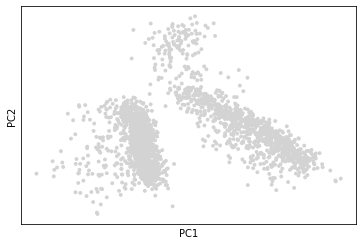

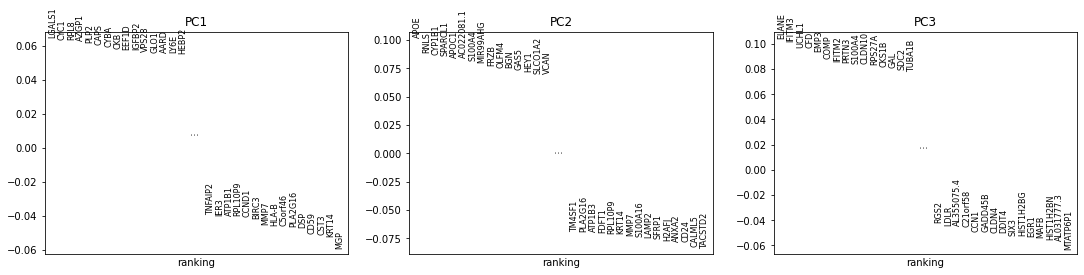

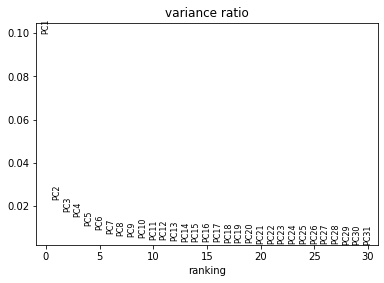

In [148]:
sc.tl.pca(adata_PDX1B_decontX_process, svd_solver='auto')
sc.pl.pca_overview(adata_PDX1B_decontX_process)

In [149]:
sc.pp.neighbors(adata_PDX1B_decontX_process, n_neighbors=15, n_pcs=15)
sc.tl.umap(adata_PDX1B_decontX_process)

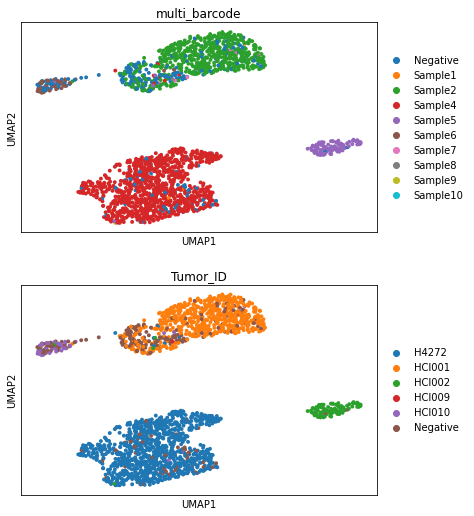

In [150]:
sc.pl.umap(adata_PDX1B_decontX_process, color=['multi_barcode','Tumor_ID'],ncols=1)

... storing 'dbscan_groups' as categorical


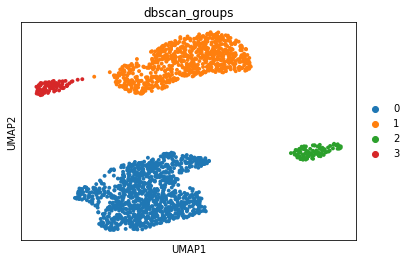

In [151]:
dbscan_umap(adata_PDX1B_decontX_process)
sc.pl.umap(adata_PDX1B_decontX_process, color=['dbscan_groups'],ncols=1)

In [152]:
adata_PDX1B_decontX_process.obs.groupby(['dbscan_groups','Tumor_ID']).apply(len)

dbscan_groups  Tumor_ID
0              H4272       990
               HCI001        2
               HCI002        1
               HCI010        2
               Negative     60
1              H4272         7
               HCI001      596
               HCI002        3
               HCI009        1
               HCI010        4
               Negative    148
2              HCI002       96
               HCI010        1
               Negative      2
3              HCI001        2
               HCI002        2
               HCI010       42
               Negative     31
dtype: int64

## Assignment

In [153]:
adata_PDX1B_decontX_process_final = adata_PDX1B_decontX_process.copy()

In [154]:
adata_PDX1B_decontX_process_final

AnnData object with n_obs × n_vars = 1990 × 14575
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'dbscan_groups_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [155]:
adata_PDX1B_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID','sort']).apply(len)

multi_barcode  Tumor_ID  sort    
Negative       Negative  Negative    241
Sample1        HCI010    tumor         4
Sample2        HCI001    tumor       594
Sample4        H4272     tumor       996
Sample5        HCI002    tumor       101
Sample6        HCI010    lung         45
Sample7        HCI001    lung          6
Sample8        HCI009    lung          1
Sample9        H4272     lung          1
Sample10       HCI002    lung          1
dtype: int64

In [156]:
adata_PDX1B_decontX_process_final.obs['Tumor_ID_updated'] = ""
for i in set(adata_PDX1B_decontX_process_final.obs['dbscan_groups']):
    temp_sub_adata = adata_PDX1B_decontX_process_final[adata_PDX1B_decontX_process_final.obs['dbscan_groups'] == i]
    temp_df = temp_sub_adata.obs.groupby(['Tumor_ID']).apply(len).to_frame()
    temp_df = temp_df.reset_index()
    temp_df = temp_df.set_index('Tumor_ID')
    adata_PDX1B_decontX_process_final.obs.loc[adata_PDX1B_decontX_process_final.obs['dbscan_groups'] == i, 'Tumor_ID_updated'] = temp_df[0].idxmax()

adata_PDX1B_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID_updated','sort']).apply(len)

multi_barcode  Tumor_ID_updated  sort    
Negative       H4272             Negative     60
               HCI001            Negative    148
               HCI002            Negative      2
               HCI010            Negative     31
Sample1        H4272             tumor         2
               HCI001            tumor         2
Sample2        H4272             tumor         2
               HCI001            tumor       590
               HCI010            tumor         2
Sample4        H4272             tumor       989
               HCI001            tumor         7
Sample5        H4272             tumor         1
               HCI001            tumor         2
               HCI002            tumor        96
               HCI010            tumor         2
Sample6        HCI001            lung          2
               HCI002            lung          1
               HCI010            lung         42
Sample7        HCI001            lung          6
Sample8        HCI001      

... storing 'Tumor_ID_updated' as categorical


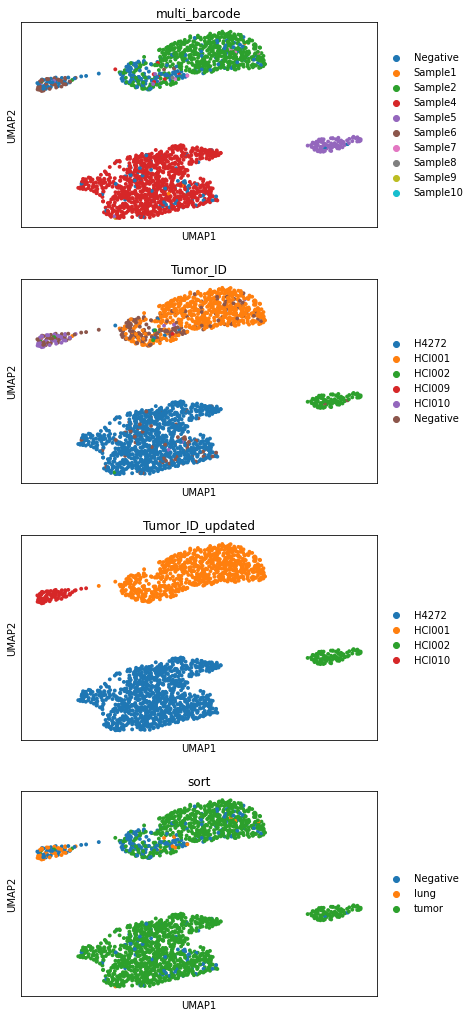

In [157]:
sc.pl.umap(adata_PDX1B_decontX_process_final, color=['multi_barcode','Tumor_ID','Tumor_ID_updated','sort'],ncols=1)

In [158]:
adata_PDX1B_decontX_final_selected = adata_PDX1B_decontX[adata_PDX1B_decontX.obs.index.isin(adata_PDX1B_decontX_process_final.obs.index.tolist())].copy()
adata_PDX1B_decontX_final_selected

AnnData object with n_obs × n_vars = 1990 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [159]:
adata_PDX1B_decontX_process_final

AnnData object with n_obs × n_vars = 1990 × 14575
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups', 'Tumor_ID_updated'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'dbscan_groups_colors', 'Tumor_ID_updated_colors', 'sort_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [160]:
adata_PDX1B_decontX_final_selected.obs['n_counts'] = adata_PDX1B_decontX_process_final.obs['n_counts']
adata_PDX1B_decontX_final_selected.obs['n_genes'] = adata_PDX1B_decontX_process_final.obs['n_genes']
adata_PDX1B_decontX_final_selected.obs['percent_mito'] = adata_PDX1B_decontX_process_final.obs['percent_mito']
adata_PDX1B_decontX_final_selected.obs['multi_barcode'] = adata_PDX1B_decontX_process_final.obs['multi_barcode']
adata_PDX1B_decontX_final_selected.obs['Tumor_ID'] = adata_PDX1B_decontX_process_final.obs['Tumor_ID']
adata_PDX1B_decontX_final_selected.obs['Tumor_ID_updated'] = adata_PDX1B_decontX_process_final.obs['Tumor_ID_updated']
adata_PDX1B_decontX_final_selected.obs['run_id'] = 'PDX1B'
adata_PDX1B_decontX_final_selected.obs.index = [i.split('-')[0]+'-2' for i in adata_PDX1B_decontX_final_selected.obs.index]
adata_PDX1B_decontX_final_selected.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort,Tumor_ID_updated,run_id
AAACCTGAGTTACGGG-2,19402.824219,3852,14.342125,Sample4,H4272,tumor,H4272,PDX1B
AAACCTGCAAGCCATT-2,11228.821289,4323,8.705716,Sample4,H4272,tumor,H4272,PDX1B
AAACCTGCAAGCTGGA-2,5753.581543,1784,12.593571,Sample2,HCI001,tumor,HCI001,PDX1B
AAACCTGGTAGGAGTC-2,3023.479492,926,41.893028,Sample4,H4272,tumor,H4272,PDX1B
AAACCTGTCCCTAATT-2,4119.676270,1447,23.879238,Sample5,HCI002,tumor,HCI002,PDX1B
...,...,...,...,...,...,...,...,...
TTTGTCAGTACATGTC-2,7630.671875,2714,15.206207,Sample2,HCI001,tumor,HCI001,PDX1B
TTTGTCAGTGTCGCTG-2,3865.428711,1245,48.167645,Sample4,H4272,tumor,H4272,PDX1B
TTTGTCAGTTCGAATC-2,6934.784180,2479,2.972870,Sample2,HCI001,tumor,HCI001,PDX1B
TTTGTCATCCGAACGC-2,5621.956055,2573,9.199254,Sample4,H4272,tumor,H4272,PDX1B


## PDX1C

In [161]:
adata_PDX1C_decontX = sc.read_csv('decontx_counts_output/decontX_PDX1C.csv')

In [162]:
adata_PDX1C_decontX = adata_PDX1C_decontX.T

In [163]:
adata_PDX1C_decontX

AnnData object with n_obs × n_vars = 2627 × 58870

In [164]:
sc.pp.filter_cells(adata_PDX1C_decontX, min_counts=0)
sc.pp.filter_cells(adata_PDX1C_decontX, min_genes=0)

In [165]:
mito_genes = adata_PDX1C_decontX.var_names.str.startswith('MT-')
adata_PDX1C_decontX.obs['percent_mito'] = np.sum(
    adata_PDX1C_decontX[:, mito_genes].X, axis=1) / np.sum(adata_PDX1C_decontX.X, axis=1) * 100


In [166]:
adata_PDX1C_decontX

AnnData object with n_obs × n_vars = 2627 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito'

In [167]:
temp_df = multi_result[multi_result['experiment'] == "PDX1_C"]
temp_df.index = [i.split('-')[0] + '-1' for i in temp_df.index]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGCTAGTGG-1,Doublet,Doublet,Doublet,PDX1_C
AAACCTGAGCTGGAAC-1,Sample4,Sample4,Sample4,PDX1_C
AAACCTGAGGGCATGT-1,Sample8,Sample8,Sample8,PDX1_C
AAACCTGAGGTGATTA-1,Sample4,Sample4,Sample4,PDX1_C
AAACCTGAGTTATCGC-1,Sample5,Sample5,Sample5,PDX1_C
...,...,...,...,...
TTTGTCATCAACGGGA-1,Sample4,Sample4,Sample4,PDX1_C
TTTGTCATCCGAATGT-1,Sample4,Sample4,Sample4,PDX1_C
TTTGTCATCCTTGGTC-1,Doublet,Doublet,Doublet,PDX1_C
TTTGTCATCGTACCGG-1,Sample2,Sample2,Sample2,PDX1_C


In [168]:
adata_PDX1C_decontX.obs.index = [i.split('.')[0]+'-1' for i in adata_PDX1C_decontX.obs.index]
adata_PDX1C_decontX.obs

,n_counts,n_genes,percent_mito
AAACCTGAGCTGGAAC-1,2742.339844,1207,28.410049
AAACCTGAGGTGATTA-1,3776.932373,1187,37.017471
AAACCTGCAACACCCG-1,6556.239746,2273,14.416692
AAACCTGCAGACAAGC-1,12975.020508,3391,6.900019
AAACCTGCATGCAACT-1,3104.456055,1422,2.797381
...,...,...,...
TTTGTCAAGCGAAGGG-1,7387.375488,2753,4.334189
TTTGTCAAGTGAATTG-1,10150.680664,3143,14.156879
TTTGTCACAGTATGCT-1,10489.845703,4374,3.614342
TTTGTCATCCGAATGT-1,4645.006348,2515,3.612879


In [169]:
temp_df = temp_df[temp_df.index.isin(adata_PDX1C_decontX.obs.index.tolist())]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGCTGGAAC-1,Sample4,Sample4,Sample4,PDX1_C
AAACCTGAGGTGATTA-1,Sample4,Sample4,Sample4,PDX1_C
AAACCTGCAACACCCG-1,Doublet,Doublet,Doublet,PDX1_C
AAACCTGCAGACAAGC-1,Doublet,Doublet,Doublet,PDX1_C
AAACCTGCATGCAACT-1,Negative,Sample4,Sample4,PDX1_C
...,...,...,...,...
TTTGTCAAGCGAAGGG-1,Sample4,Sample4,Sample4,PDX1_C
TTTGTCAAGTGAATTG-1,Doublet,Doublet,Doublet,PDX1_C
TTTGTCACAGTATGCT-1,Sample4,Sample4,Sample4,PDX1_C
TTTGTCATCCGAATGT-1,Sample4,Sample4,Sample4,PDX1_C


In [170]:
adata_PDX1C_decontX.obs['multi_barcode'] = "Negative"
for i in temp_df.index:
    adata_PDX1C_decontX.obs.loc[i, 'multi_barcode'] = temp_df.loc[i, 'MULTI']

In [171]:
myList = list(set(adata_PDX1C_decontX.obs['multi_barcode']))

auxdict = dict(multi_barcodes_metadata['Tumor'][myList])
adata_PDX1C_decontX.obs['Tumor_ID'] = adata_PDX1C_decontX.obs['multi_barcode'].map(auxdict)
auxdict = dict(multi_barcodes_metadata['Tissue'][myList])
adata_PDX1C_decontX.obs['sort'] = adata_PDX1C_decontX.obs['multi_barcode'].map(auxdict)

In [172]:
adata_PDX1C_decontX.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort
AAACCTGAGCTGGAAC-1,2742.339844,1207,28.410049,Sample4,H4272,tumor
AAACCTGAGGTGATTA-1,3776.932373,1187,37.017471,Sample4,H4272,tumor
AAACCTGCAACACCCG-1,6556.239746,2273,14.416692,Doublet,Doublet,Doublet
AAACCTGCAGACAAGC-1,12975.020508,3391,6.900019,Doublet,Doublet,Doublet
AAACCTGCATGCAACT-1,3104.456055,1422,2.797381,Negative,Negative,Negative
...,...,...,...,...,...,...
TTTGTCAAGCGAAGGG-1,7387.375488,2753,4.334189,Sample4,H4272,tumor
TTTGTCAAGTGAATTG-1,10150.680664,3143,14.156879,Doublet,Doublet,Doublet
TTTGTCACAGTATGCT-1,10489.845703,4374,3.614342,Sample4,H4272,tumor
TTTGTCATCCGAATGT-1,4645.006348,2515,3.612879,Sample4,H4272,tumor


## embedding

In [173]:
adata_PDX1C_decontX_process = adata_PDX1C_decontX.copy()

In [174]:
adata_PDX1C_decontX_process

AnnData object with n_obs × n_vars = 2627 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [175]:
adata_PDX1C_decontX_process = adata_PDX1C_decontX_process[~adata_PDX1C_decontX_process.obs['multi_barcode'].isin(['Doublet'])]
sc.pp.filter_cells(adata_PDX1C_decontX_process, min_counts=2500)
sc.pp.filter_cells(adata_PDX1C_decontX_process, min_genes=250)
adata_PDX1C_decontX_process = adata_PDX1C_decontX_process[adata_PDX1C_decontX_process.obs['percent_mito'] <= 50]
adata_PDX1C_decontX_process

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 2086 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [176]:
sc.pp.filter_genes(adata_PDX1C_decontX_process, min_cells=20)
sc.pp.highly_variable_genes(adata_PDX1C_decontX_process, n_top_genes=2000,flavor='seurat_v3')
sc.pp.normalize_per_cell(adata_PDX1C_decontX_process, counts_per_cell_after=1e4)
sc.pp.log1p(adata_PDX1C_decontX_process)

Trying to set attribute `.var` of view, copying.
/home/weilun/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.


In [177]:
adata_PDX1C_decontX_process

AnnData object with n_obs × n_vars = 2086 × 14537
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [178]:
adata_PDX1C_decontX_process.raw = adata_PDX1C_decontX_process
sc.tl.score_genes_cell_cycle(adata_PDX1C_decontX_process, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata_PDX1C_decontX_process, ['S_score', 'G2M_score'])
sc.pp.scale(adata_PDX1C_decontX_process,max_value=10)

... storing 'multi_barcode' as categorical
... storing 'Tumor_ID' as categorical
... storing 'sort' as categorical
... storing 'phase' as categorical


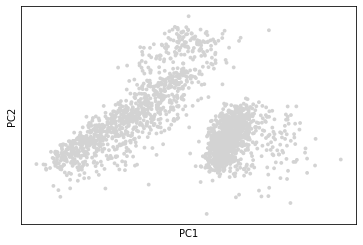

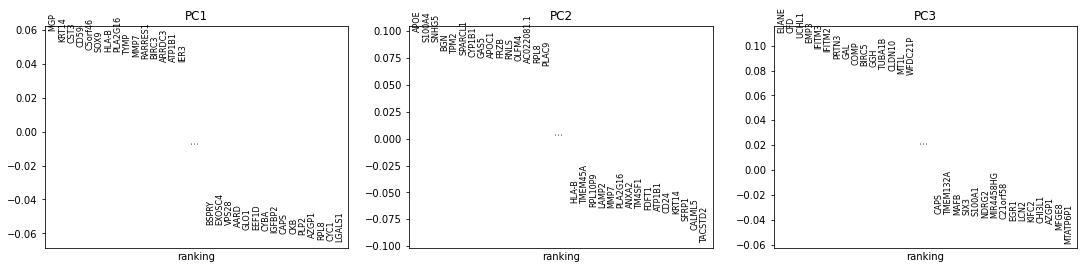

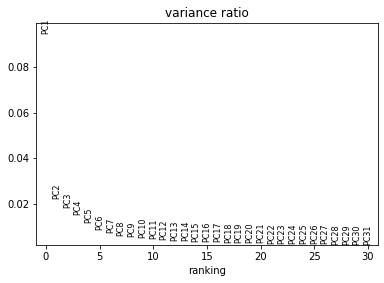

In [179]:
sc.tl.pca(adata_PDX1C_decontX_process, svd_solver='auto')
sc.pl.pca_overview(adata_PDX1C_decontX_process)

In [180]:
sc.pp.neighbors(adata_PDX1C_decontX_process, n_neighbors=15, n_pcs=15)
sc.tl.umap(adata_PDX1C_decontX_process)

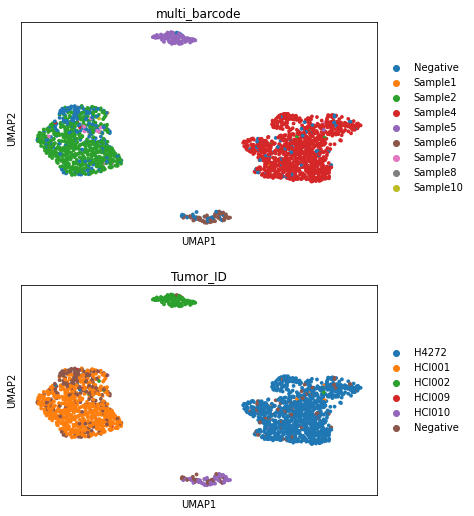

In [181]:
sc.pl.umap(adata_PDX1C_decontX_process, color=['multi_barcode','Tumor_ID'],ncols=1)

... storing 'dbscan_groups' as categorical


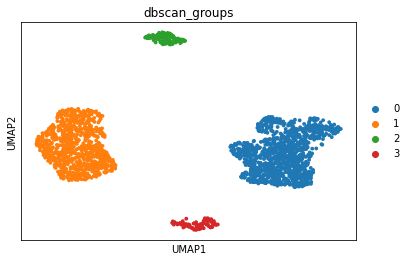

In [182]:
dbscan_umap(adata_PDX1C_decontX_process)
sc.pl.umap(adata_PDX1C_decontX_process, color=['dbscan_groups'],ncols=1)

In [183]:
adata_PDX1C_decontX_process.obs.groupby(['dbscan_groups','Tumor_ID']).apply(len)

dbscan_groups  Tumor_ID
0              H4272       1005
               HCI001         5
               HCI002         1
               HCI010         1
               Negative      58
1              H4272          3
               HCI001       615
               HCI002         5
               HCI009         4
               HCI010         2
               Negative     198
2              HCI002        98
               Negative       2
3              H4272          1
               HCI010        56
               Negative      32
dtype: int64

## Assignment

In [184]:
adata_PDX1C_decontX_process_final = adata_PDX1C_decontX_process.copy()

In [185]:
adata_PDX1C_decontX_process_final

AnnData object with n_obs × n_vars = 2086 × 14537
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'dbscan_groups_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [186]:
adata_PDX1C_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID','sort']).apply(len)

multi_barcode  Tumor_ID  sort    
Negative       Negative  Negative     290
Sample1        HCI010    tumor          3
Sample2        HCI001    tumor        609
Sample4        H4272     tumor       1009
Sample5        HCI002    tumor        103
Sample6        HCI010    lung          56
Sample7        HCI001    lung          11
Sample8        HCI009    lung           4
Sample10       HCI002    lung           1
dtype: int64

In [187]:
adata_PDX1C_decontX_process_final.obs['Tumor_ID_updated'] = ""
for i in set(adata_PDX1C_decontX_process_final.obs['dbscan_groups']):
    temp_sub_adata = adata_PDX1C_decontX_process_final[adata_PDX1C_decontX_process_final.obs['dbscan_groups'] == i]
    temp_df = temp_sub_adata.obs.groupby(['Tumor_ID']).apply(len).to_frame()
    temp_df = temp_df.reset_index()
    temp_df = temp_df.set_index('Tumor_ID')
    adata_PDX1C_decontX_process_final.obs.loc[adata_PDX1C_decontX_process_final.obs['dbscan_groups'] == i, 'Tumor_ID_updated'] = temp_df[0].idxmax()

adata_PDX1C_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID_updated','sort']).apply(len)

multi_barcode  Tumor_ID_updated  sort    
Negative       H4272             Negative      58
               HCI001            Negative     198
               HCI002            Negative       2
               HCI010            Negative      32
Sample1        H4272             tumor          1
               HCI001            tumor          1
               HCI010            tumor          1
Sample2        H4272             tumor          4
               HCI001            tumor        605
Sample4        H4272             tumor       1005
               HCI001            tumor          3
               HCI010            tumor          1
Sample5        H4272             tumor          1
               HCI001            tumor          4
               HCI002            tumor         98
Sample6        HCI001            lung           1
               HCI010            lung          55
Sample7        H4272             lung           1
               HCI001            lung          10
Sample8 

... storing 'Tumor_ID_updated' as categorical


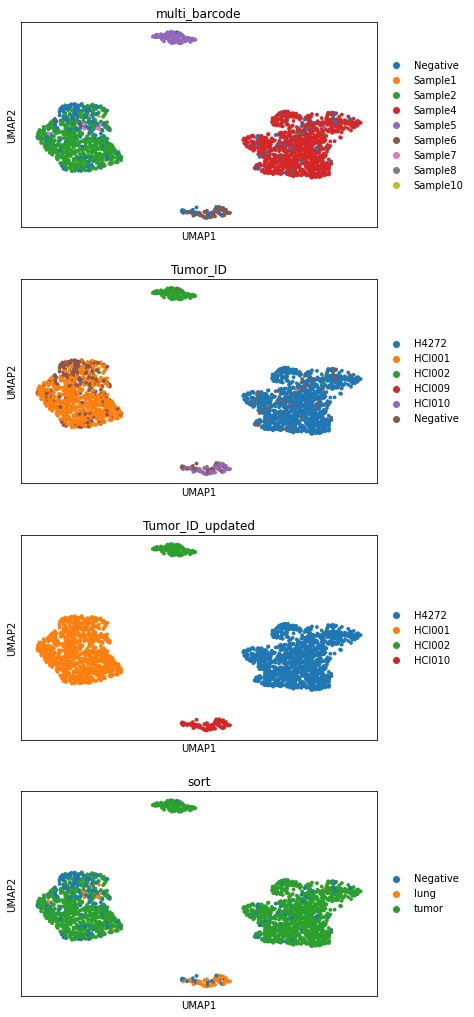

In [188]:
sc.pl.umap(adata_PDX1C_decontX_process_final, color=['multi_barcode','Tumor_ID','Tumor_ID_updated','sort'],ncols=1)

In [189]:
adata_PDX1C_decontX_final_selected = adata_PDX1C_decontX[adata_PDX1C_decontX.obs.index.isin(adata_PDX1C_decontX_process_final.obs.index.tolist())].copy()
adata_PDX1C_decontX_final_selected

AnnData object with n_obs × n_vars = 2086 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [190]:
adata_PDX1C_decontX_final_selected

AnnData object with n_obs × n_vars = 2086 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [191]:
adata_PDX1C_decontX_final_selected.obs['n_counts'] = adata_PDX1C_decontX_process_final.obs['n_counts']
adata_PDX1C_decontX_final_selected.obs['n_genes'] = adata_PDX1C_decontX_process_final.obs['n_genes']
adata_PDX1C_decontX_final_selected.obs['percent_mito'] = adata_PDX1C_decontX_process_final.obs['percent_mito']
adata_PDX1C_decontX_final_selected.obs['multi_barcode'] = adata_PDX1C_decontX_process_final.obs['multi_barcode']
adata_PDX1C_decontX_final_selected.obs['Tumor_ID'] = adata_PDX1C_decontX_process_final.obs['Tumor_ID']
adata_PDX1C_decontX_final_selected.obs['Tumor_ID_updated'] = adata_PDX1C_decontX_process_final.obs['Tumor_ID_updated']
adata_PDX1C_decontX_final_selected.obs['run_id'] = 'PDX1C'
adata_PDX1C_decontX_final_selected.obs.index = [i.split('-')[0]+'-3' for i in adata_PDX1C_decontX_final_selected.obs.index]
adata_PDX1C_decontX_final_selected.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort,Tumor_ID_updated,run_id
AAACCTGAGCTGGAAC-3,2741.339844,1207,28.410049,Sample4,H4272,tumor,H4272,PDX1C
AAACCTGAGGTGATTA-3,3768.661865,1187,37.017471,Sample4,H4272,tumor,H4272,PDX1C
AAACCTGCATGCAACT-3,3097.878418,1422,2.797381,Negative,Negative,Negative,H4272,PDX1C
AAACCTGTCGTCGTTC-3,10808.547852,3040,9.713645,Sample4,H4272,tumor,H4272,PDX1C
AAACGGGAGCGTTTAC-3,3436.462402,1297,18.732599,Sample4,H4272,tumor,H4272,PDX1C
...,...,...,...,...,...,...,...,...
TTTGTCAAGATCTGAA-3,14821.179688,3910,1.556502,Sample6,HCI010,lung,HCI010,PDX1C
TTTGTCAAGCGAAGGG-3,7373.151855,2753,4.334189,Sample4,H4272,tumor,H4272,PDX1C
TTTGTCACAGTATGCT-3,10470.346680,4374,3.614342,Sample4,H4272,tumor,H4272,PDX1C
TTTGTCATCCGAATGT-3,4613.337891,2515,3.612879,Sample4,H4272,tumor,H4272,PDX1C


## PDX1D

In [192]:
adata_PDX1D_decontX = sc.read_csv('decontx_counts_output/decontX_PDX1D.csv')

In [193]:
adata_PDX1D_decontX = adata_PDX1D_decontX.T

In [194]:
adata_PDX1D_decontX

AnnData object with n_obs × n_vars = 2476 × 58870

In [195]:
sc.pp.filter_cells(adata_PDX1D_decontX, min_counts=0)
sc.pp.filter_cells(adata_PDX1D_decontX, min_genes=0)

In [196]:
mito_genes = adata_PDX1D_decontX.var_names.str.startswith('MT-')
adata_PDX1D_decontX.obs['percent_mito'] = np.sum(
    adata_PDX1D_decontX[:, mito_genes].X, axis=1) / np.sum(adata_PDX1D_decontX.X, axis=1) * 100


In [197]:
adata_PDX1D_decontX

AnnData object with n_obs × n_vars = 2476 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito'

In [198]:
temp_df = multi_result[multi_result['experiment'] == "PDX1_D"]
temp_df.index = [i.split('-')[0] + '-1' for i in temp_df.index]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGAAGGACA-1,Sample5,Sample5,Sample5,PDX1_D
AAACCTGAGAATCTCC-1,Sample4,Sample4,Sample4,PDX1_D
AAACCTGAGCGATAGC-1,Sample7,Sample7,Sample7,PDX1_D
AAACCTGAGCTTCGCG-1,Negative,Sample2,Sample2,PDX1_D
AAACCTGAGTTCGCAT-1,Sample6,Sample6,Sample6,PDX1_D
...,...,...,...,...
TTTGTCATCCGTACAA-1,Sample4,Sample4,Sample4,PDX1_D
TTTGTCATCGGAAATA-1,Sample9,Sample9,Sample9,PDX1_D
TTTGTCATCTAACTGG-1,Sample6,Sample6,Sample6,PDX1_D
TTTGTCATCTCGTTTA-1,Sample4,Sample4,Sample4,PDX1_D


In [199]:
adata_PDX1D_decontX.obs.index = [i.split('.')[0]+'-1' for i in adata_PDX1D_decontX.obs.index]
adata_PDX1D_decontX.obs

,n_counts,n_genes,percent_mito
AAACCTGAGAATCTCC-1,3127.494873,1063,19.114782
AAACCTGAGCTTCGCG-1,3340.568604,874,37.337162
AAACCTGAGTTCGCAT-1,13623.793945,3376,3.400564
AAACCTGCACCAGGCT-1,2498.180664,1071,10.354065
AAACCTGGTTGGTAAA-1,15799.238281,4011,28.145706
...,...,...,...
TTTGGTTGTCACTGGC-1,24504.777344,4764,21.427002
TTTGTCACACCAGGTC-1,5178.424316,1843,6.991874
TTTGTCACAGGCTGAA-1,6526.054688,1068,7.149474
TTTGTCAGTGATAAGT-1,3038.986328,1297,21.335293


In [200]:
temp_df = temp_df[temp_df.index.isin(adata_PDX1D_decontX.obs.index.tolist())]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGAATCTCC-1,Sample4,Sample4,Sample4,PDX1_D
AAACCTGAGCTTCGCG-1,Negative,Sample2,Sample2,PDX1_D
AAACCTGAGTTCGCAT-1,Sample6,Sample6,Sample6,PDX1_D
AAACCTGCACCAGGCT-1,Sample4,Sample4,Sample4,PDX1_D
AAACCTGGTTGGTAAA-1,Doublet,Doublet,Doublet,PDX1_D
...,...,...,...,...
TTTGGTTGTCACTGGC-1,Doublet,Doublet,Doublet,PDX1_D
TTTGTCACACCAGGTC-1,Sample4,Sample4,Sample4,PDX1_D
TTTGTCACAGGCTGAA-1,Sample2,Sample2,Sample2,PDX1_D
TTTGTCAGTGATAAGT-1,Sample4,Sample4,Sample4,PDX1_D


In [201]:
adata_PDX1D_decontX.obs['multi_barcode'] = "Negative"
for i in temp_df.index:
    adata_PDX1D_decontX.obs.loc[i, 'multi_barcode'] = temp_df.loc[i, 'MULTI']

In [202]:
myList = list(set(adata_PDX1D_decontX.obs['multi_barcode']))

auxdict = dict(multi_barcodes_metadata['Tumor'][myList])
adata_PDX1D_decontX.obs['Tumor_ID'] = adata_PDX1D_decontX.obs['multi_barcode'].map(auxdict)
auxdict = dict(multi_barcodes_metadata['Tissue'][myList])
adata_PDX1D_decontX.obs['sort'] = adata_PDX1D_decontX.obs['multi_barcode'].map(auxdict)

In [203]:
adata_PDX1D_decontX.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort
AAACCTGAGAATCTCC-1,3127.494873,1063,19.114782,Sample4,H4272,tumor
AAACCTGAGCTTCGCG-1,3340.568604,874,37.337162,Negative,Negative,Negative
AAACCTGAGTTCGCAT-1,13623.793945,3376,3.400564,Sample6,HCI010,lung
AAACCTGCACCAGGCT-1,2498.180664,1071,10.354065,Sample4,H4272,tumor
AAACCTGGTTGGTAAA-1,15799.238281,4011,28.145706,Doublet,Doublet,Doublet
...,...,...,...,...,...,...
TTTGGTTGTCACTGGC-1,24504.777344,4764,21.427002,Doublet,Doublet,Doublet
TTTGTCACACCAGGTC-1,5178.424316,1843,6.991874,Sample4,H4272,tumor
TTTGTCACAGGCTGAA-1,6526.054688,1068,7.149474,Sample2,HCI001,tumor
TTTGTCAGTGATAAGT-1,3038.986328,1297,21.335293,Sample4,H4272,tumor


## embedding

In [204]:
adata_PDX1D_decontX_process = adata_PDX1D_decontX.copy()

In [205]:
adata_PDX1D_decontX_process

AnnData object with n_obs × n_vars = 2476 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [206]:
adata_PDX1D_decontX_process = adata_PDX1D_decontX_process[~adata_PDX1D_decontX_process.obs['multi_barcode'].isin(['Doublet'])]
sc.pp.filter_cells(adata_PDX1D_decontX_process, min_counts=2500)
sc.pp.filter_cells(adata_PDX1D_decontX_process, min_genes=250)
adata_PDX1D_decontX_process = adata_PDX1D_decontX_process[adata_PDX1D_decontX_process.obs['percent_mito'] <= 50]
adata_PDX1D_decontX_process

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 1976 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [207]:
sc.pp.filter_genes(adata_PDX1D_decontX_process, min_cells=20)
sc.pp.highly_variable_genes(adata_PDX1D_decontX_process, n_top_genes=2000,flavor='seurat_v3')
sc.pp.normalize_per_cell(adata_PDX1D_decontX_process, counts_per_cell_after=1e4)
sc.pp.log1p(adata_PDX1D_decontX_process)

Trying to set attribute `.var` of view, copying.
/home/weilun/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.


In [208]:
adata_PDX1D_decontX_process

AnnData object with n_obs × n_vars = 1976 × 14415
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [209]:
adata_PDX1D_decontX_process.raw = adata_PDX1D_decontX_process
sc.tl.score_genes_cell_cycle(adata_PDX1D_decontX_process, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata_PDX1D_decontX_process, ['S_score', 'G2M_score'])
sc.pp.scale(adata_PDX1D_decontX_process,max_value=10)

... storing 'multi_barcode' as categorical
... storing 'Tumor_ID' as categorical
... storing 'sort' as categorical
... storing 'phase' as categorical


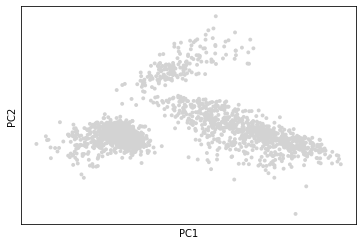

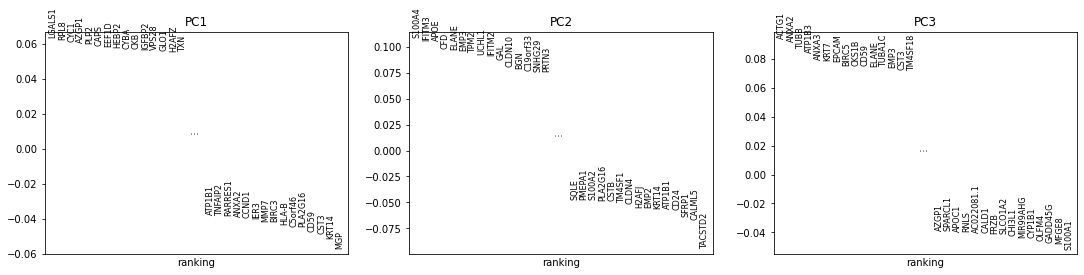

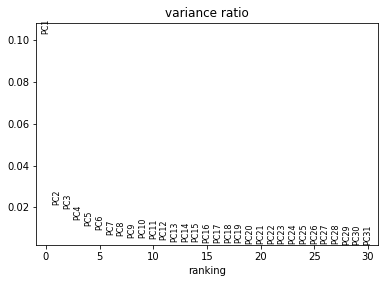

In [210]:
sc.tl.pca(adata_PDX1D_decontX_process, svd_solver='auto')
sc.pl.pca_overview(adata_PDX1D_decontX_process)

In [211]:
sc.pp.neighbors(adata_PDX1D_decontX_process, n_neighbors=15, n_pcs=15)
sc.tl.umap(adata_PDX1D_decontX_process)

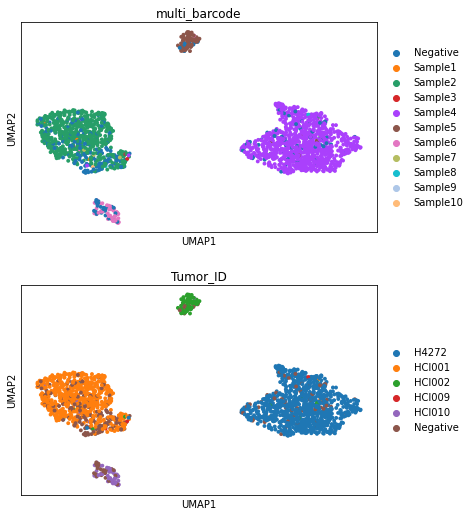

In [212]:
sc.pl.umap(adata_PDX1D_decontX_process, color=['multi_barcode','Tumor_ID'],ncols=1)

... storing 'dbscan_groups' as categorical


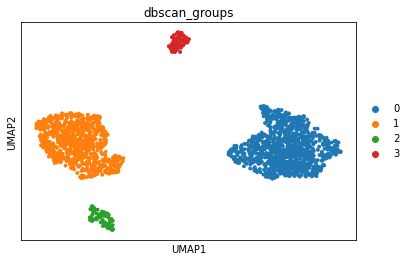

In [213]:
dbscan_umap(adata_PDX1D_decontX_process)
sc.pl.umap(adata_PDX1D_decontX_process, color=['dbscan_groups'],ncols=1)

In [214]:
adata_PDX1D_decontX_process.obs.groupby(['dbscan_groups','Tumor_ID']).apply(len)

dbscan_groups  Tumor_ID
0              H4272       963
               HCI001        3
               HCI002        5
               HCI009        1
               Negative     63
1              H4272         5
               HCI001      586
               HCI002        4
               HCI009        2
               HCI010        4
               Negative    169
2              H4272         1
               HCI010       53
               Negative     30
3              HCI002       77
               HCI010        1
               Negative      9
dtype: int64

## Assignment

In [215]:
adata_PDX1D_decontX_process_final = adata_PDX1D_decontX_process.copy()

In [216]:
adata_PDX1D_decontX_process_final

AnnData object with n_obs × n_vars = 1976 × 14415
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'dbscan_groups_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [217]:
adata_PDX1D_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID','sort']).apply(len)

multi_barcode  Tumor_ID  sort    
Negative       Negative  Negative    271
Sample1        HCI010    tumor         3
Sample2        HCI001    tumor       584
Sample3        HCI009    tumor         1
Sample4        H4272     tumor       967
Sample5        HCI002    tumor        85
Sample6        HCI010    lung         55
Sample7        HCI001    lung          5
Sample8        HCI009    lung          2
Sample9        H4272     lung          2
Sample10       HCI002    lung          1
dtype: int64

In [218]:
adata_PDX1D_decontX_process_final.obs['Tumor_ID_updated'] = ""
for i in set(adata_PDX1D_decontX_process_final.obs['dbscan_groups']):
    temp_sub_adata = adata_PDX1D_decontX_process_final[adata_PDX1D_decontX_process_final.obs['dbscan_groups'] == i]
    temp_df = temp_sub_adata.obs.groupby(['Tumor_ID']).apply(len).to_frame()
    temp_df = temp_df.reset_index()
    temp_df = temp_df.set_index('Tumor_ID')
    adata_PDX1D_decontX_process_final.obs.loc[adata_PDX1D_decontX_process_final.obs['dbscan_groups'] == i, 'Tumor_ID_updated'] = temp_df[0].idxmax()

adata_PDX1D_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID_updated','sort']).apply(len)

multi_barcode  Tumor_ID_updated  sort    
Negative       H4272             Negative     63
               HCI001            Negative    169
               HCI002            Negative      9
               HCI010            Negative     30
Sample1        HCI001            tumor         3
Sample2        H4272             tumor         3
               HCI001            tumor       581
Sample3        HCI001            tumor         1
Sample4        H4272             tumor       963
               HCI001            tumor         4
Sample5        H4272             tumor         5
               HCI001            tumor         3
               HCI002            tumor        77
Sample6        HCI001            lung          1
               HCI002            lung          1
               HCI010            lung         53
Sample7        HCI001            lung          5
Sample8        H4272             lung          1
               HCI001            lung          1
Sample9        HCI001      

... storing 'Tumor_ID_updated' as categorical


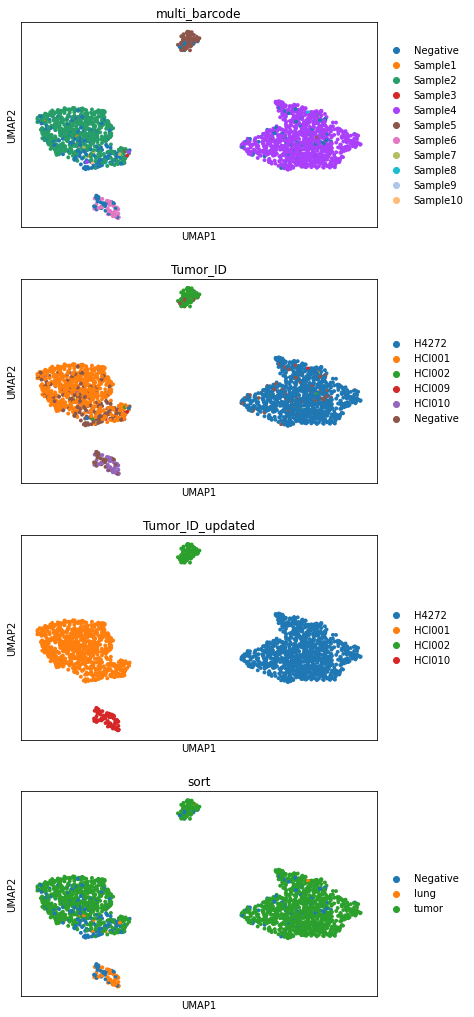

In [219]:
sc.pl.umap(adata_PDX1D_decontX_process_final, color=['multi_barcode','Tumor_ID','Tumor_ID_updated','sort'],ncols=1)

In [220]:
adata_PDX1D_decontX_final_selected = adata_PDX1D_decontX[adata_PDX1D_decontX.obs.index.isin(adata_PDX1D_decontX_process_final.obs.index.tolist())].copy()
adata_PDX1D_decontX_final_selected

AnnData object with n_obs × n_vars = 1976 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [221]:
adata_PDX1D_decontX_process_final

AnnData object with n_obs × n_vars = 1976 × 14415
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups', 'Tumor_ID_updated'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'dbscan_groups_colors', 'Tumor_ID_updated_colors', 'sort_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [222]:
adata_PDX1D_decontX_final_selected.obs['n_counts'] = adata_PDX1D_decontX_process_final.obs['n_counts']
adata_PDX1D_decontX_final_selected.obs['n_genes'] = adata_PDX1D_decontX_process_final.obs['n_genes']
adata_PDX1D_decontX_final_selected.obs['percent_mito'] = adata_PDX1D_decontX_process_final.obs['percent_mito']
adata_PDX1D_decontX_final_selected.obs['multi_barcode'] = adata_PDX1D_decontX_process_final.obs['multi_barcode']
adata_PDX1D_decontX_final_selected.obs['Tumor_ID'] = adata_PDX1D_decontX_process_final.obs['Tumor_ID']
adata_PDX1D_decontX_final_selected.obs['Tumor_ID_updated'] = adata_PDX1D_decontX_process_final.obs['Tumor_ID_updated']
adata_PDX1D_decontX_final_selected.obs['run_id'] = 'PDX1D'
adata_PDX1D_decontX_final_selected.obs.index = [i.split('-')[0]+'-4' for i in adata_PDX1D_decontX_final_selected.obs.index]
adata_PDX1D_decontX_final_selected.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort,Tumor_ID_updated,run_id
AAACCTGAGAATCTCC-4,3110.593750,1063,19.114782,Sample4,H4272,tumor,H4272,PDX1D
AAACCTGAGCTTCGCG-4,3336.690918,874,37.337162,Negative,Negative,Negative,HCI001,PDX1D
AAACCTGAGTTCGCAT-4,13596.627930,3376,3.400564,Sample6,HCI010,lung,HCI010,PDX1D
AAACGGGAGTGTGGCA-4,2856.805664,1451,32.265659,Negative,Negative,Negative,H4272,PDX1D
AAACGGGCAGCCTGTG-4,16863.218750,3580,17.084917,Sample2,HCI001,tumor,HCI001,PDX1D
...,...,...,...,...,...,...,...,...
TTTGGTTCAAACGCGA-4,8154.122559,2209,23.702410,Sample2,HCI001,tumor,HCI001,PDX1D
TTTGGTTGTAGCTGCC-4,2795.079590,903,17.430197,Sample5,HCI002,tumor,HCI002,PDX1D
TTTGTCACACCAGGTC-4,5169.543457,1843,6.991874,Sample4,H4272,tumor,H4272,PDX1D
TTTGTCACAGGCTGAA-4,6525.051758,1068,7.149474,Sample2,HCI001,tumor,HCI001,PDX1D


## PDX2LT

In [223]:
adata_PDX2LT_decontX = sc.read_csv('decontx_counts_output/decontX_PDX2LT.csv')

In [224]:
adata_PDX2LT_decontX = adata_PDX2LT_decontX.T

In [225]:
adata_PDX2LT_decontX

AnnData object with n_obs × n_vars = 10096 × 58870

In [226]:
sc.pp.filter_cells(adata_PDX2LT_decontX, min_counts=0)
sc.pp.filter_cells(adata_PDX2LT_decontX, min_genes=0)

In [227]:
mito_genes = adata_PDX2LT_decontX.var_names.str.startswith('MT-')
adata_PDX2LT_decontX.obs['percent_mito'] = np.sum(
    adata_PDX2LT_decontX[:, mito_genes].X, axis=1) / np.sum(adata_PDX2LT_decontX.X, axis=1) * 100


In [228]:
adata_PDX2LT_decontX

AnnData object with n_obs × n_vars = 10096 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito'

In [229]:
temp_df = multi_result[multi_result['experiment'] == "PDX2_LT"]
temp_df.index = [i.split('-')[0] + '-1' for i in temp_df.index]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGCAGCGTA-1,Doublet,Doublet,Doublet,PDX2_LT
AAACCTGAGGACCACA-1,Negative,NaN,NaN,PDX2_LT
AAACCTGAGTCGTTTG-1,Bar74,Bar74,Bar74,PDX2_LT
AAACCTGCAATAAGCA-1,Negative,NaN,NaN,PDX2_LT
AAACCTGCACACAGAG-1,Bar50,Bar50,Bar50,PDX2_LT
...,...,...,...,...
TTTGTCAGTTCCAACA-1,Negative,NaN,NaN,PDX2_LT
TTTGTCAGTTTAGGAA-1,Bar50,Bar50,Bar50,PDX2_LT
TTTGTCATCAGTACGT-1,Bar50,Bar50,Bar50,PDX2_LT
TTTGTCATCCCGGATG-1,Sample27,Bar2,Bar2,PDX2_LT


In [230]:
adata_PDX2LT_decontX.obs.index = [i.split('.')[0]+'-1' for i in adata_PDX2LT_decontX.obs.index]
adata_PDX2LT_decontX.obs

,n_counts,n_genes,percent_mito
AAACCTGAGCAGCGTA-1,5558.080078,2530,5.720356
AAACCTGAGTCGTTTG-1,3487.291748,1370,5.184875
AAACCTGCACACAGAG-1,6610.864746,2397,5.642227
AAACCTGCACTTCTGC-1,4738.368652,1808,2.089326
AAACCTGCAGCTGCTG-1,4042.424072,1321,3.017993
...,...,...,...
TTTGTCAGTTAGAACA-1,5900.957031,2354,1.709161
TTTGTCAGTTTAGGAA-1,6796.395020,2164,1.427228
TTTGTCATCAGTACGT-1,4827.467773,1888,2.796499
TTTGTCATCCCGGATG-1,2425.522461,776,1.152263


In [231]:
temp_df = temp_df[temp_df.index.isin(adata_PDX2LT_decontX.obs.index.tolist())]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGCAGCGTA-1,Doublet,Doublet,Doublet,PDX2_LT
AAACCTGAGTCGTTTG-1,Bar74,Bar74,Bar74,PDX2_LT
AAACCTGCACACAGAG-1,Bar50,Bar50,Bar50,PDX2_LT
AAACCTGCACTTCTGC-1,Negative,NaN,NaN,PDX2_LT
AAACCTGCAGCTGCTG-1,Bar50,Bar50,Bar50,PDX2_LT
...,...,...,...,...
TTTGTCAGTTAGAACA-1,Bar74,Bar74,Bar74,PDX2_LT
TTTGTCAGTTTAGGAA-1,Bar50,Bar50,Bar50,PDX2_LT
TTTGTCATCAGTACGT-1,Bar50,Bar50,Bar50,PDX2_LT
TTTGTCATCCCGGATG-1,Sample27,Bar2,Bar2,PDX2_LT


In [232]:
adata_PDX2LT_decontX.obs['multi_barcode'] = "Negative"
for i in temp_df.index:
    adata_PDX2LT_decontX.obs.loc[i, 'multi_barcode'] = temp_df.loc[i, 'MULTI']

In [233]:
myList = list(set(adata_PDX2LT_decontX.obs['multi_barcode']))

auxdict = dict(multi_barcodes_metadata['Tumor'][myList])
adata_PDX2LT_decontX.obs['Tumor_ID'] = adata_PDX2LT_decontX.obs['multi_barcode'].map(auxdict)
auxdict = dict(multi_barcodes_metadata['Tissue'][myList])
adata_PDX2LT_decontX.obs['sort'] = adata_PDX2LT_decontX.obs['multi_barcode'].map(auxdict)

In [234]:
adata_PDX2LT_decontX.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort
AAACCTGAGCAGCGTA-1,5558.080078,2530,5.720356,Doublet,Doublet,Doublet
AAACCTGAGTCGTTTG-1,3487.291748,1370,5.184875,Bar74,HCI010,tumor
AAACCTGCACACAGAG-1,6610.864746,2397,5.642227,Bar50,HCI010,tumor
AAACCTGCACTTCTGC-1,4738.368652,1808,2.089326,Negative,Negative,Negative
AAACCTGCAGCTGCTG-1,4042.424072,1321,3.017993,Bar50,HCI010,tumor
...,...,...,...,...,...,...
TTTGTCAGTTAGAACA-1,5900.957031,2354,1.709161,Bar74,HCI010,tumor
TTTGTCAGTTTAGGAA-1,6796.395020,2164,1.427228,Bar50,HCI010,tumor
TTTGTCATCAGTACGT-1,4827.467773,1888,2.796499,Bar50,HCI010,tumor
TTTGTCATCCCGGATG-1,2425.522461,776,1.152263,Sample27,HCI010,tumor


## embedding

In [235]:
adata_PDX2LT_decontX_process = adata_PDX2LT_decontX.copy()

In [236]:
adata_PDX2LT_decontX_process

AnnData object with n_obs × n_vars = 10096 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [237]:
adata_PDX2LT_decontX_process = adata_PDX2LT_decontX_process[adata_PDX2LT_decontX_process.obs['multi_barcode'].isin(['Bar74'])]
sc.pp.filter_cells(adata_PDX2LT_decontX_process, min_counts=2500)
sc.pp.filter_cells(adata_PDX2LT_decontX_process, min_genes=250)
adata_PDX2LT_decontX_process = adata_PDX2LT_decontX_process[adata_PDX2LT_decontX_process.obs['percent_mito'] <= 50]
adata_PDX2LT_decontX_process

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 1402 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [238]:
sc.pp.filter_genes(adata_PDX2LT_decontX_process, min_cells=20)
sc.pp.highly_variable_genes(adata_PDX2LT_decontX_process, n_top_genes=2000,flavor='seurat_v3')
sc.pp.normalize_per_cell(adata_PDX2LT_decontX_process, counts_per_cell_after=1e4)
sc.pp.log1p(adata_PDX2LT_decontX_process)

Trying to set attribute `.var` of view, copying.
/home/weilun/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.


In [239]:
adata_PDX2LT_decontX_process.raw = adata_PDX2LT_decontX_process
sc.tl.score_genes_cell_cycle(adata_PDX2LT_decontX_process, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata_PDX2LT_decontX_process, ['S_score', 'G2M_score'])
sc.pp.scale(adata_PDX2LT_decontX_process,max_value=10)

... storing 'multi_barcode' as categorical
... storing 'Tumor_ID' as categorical
... storing 'sort' as categorical
... storing 'phase' as categorical


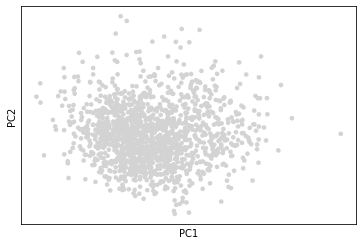

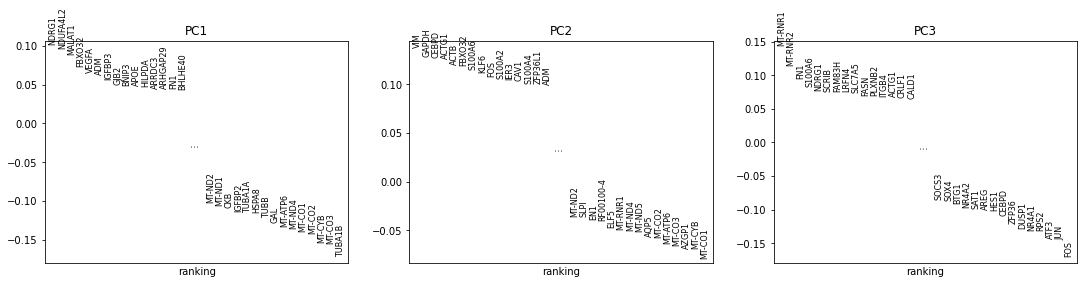

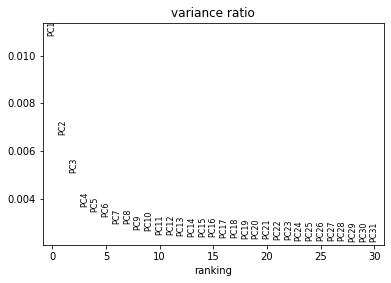

In [240]:
sc.tl.pca(adata_PDX2LT_decontX_process, svd_solver='auto')
sc.pl.pca_overview(adata_PDX2LT_decontX_process)

In [241]:
sc.pp.neighbors(adata_PDX2LT_decontX_process, n_neighbors=15, n_pcs=25)
sc.tl.umap(adata_PDX2LT_decontX_process)

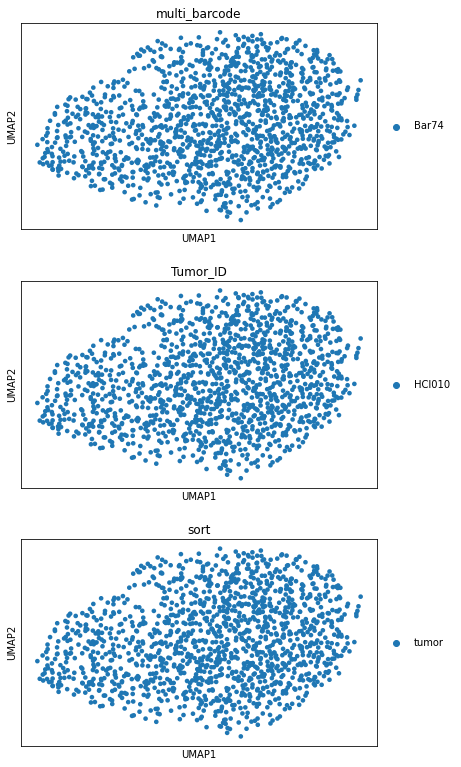

In [242]:
sc.pl.umap(adata_PDX2LT_decontX_process, color=['multi_barcode','Tumor_ID','sort'],ncols=1)

... storing 'dbscan_groups' as categorical


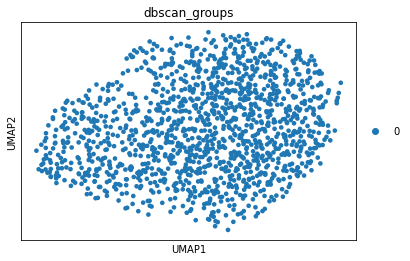

In [243]:
dbscan_umap(adata_PDX2LT_decontX_process)
sc.pl.umap(adata_PDX2LT_decontX_process, color=['dbscan_groups'],ncols=1)

In [244]:
adata_PDX2LT_decontX_process.obs.groupby(['dbscan_groups','Tumor_ID']).apply(len)

dbscan_groups  Tumor_ID
0              HCI010      1402
dtype: int64

## Assignment

In [245]:
adata_PDX2LT_decontX_process_final = adata_PDX2LT_decontX_process.copy()

In [246]:
adata_PDX2LT_decontX_process_final

AnnData object with n_obs × n_vars = 1402 × 11699
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'sort_colors', 'dbscan_groups_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [247]:
adata_PDX2LT_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID','sort']).apply(len)

multi_barcode  Tumor_ID  sort 
Bar74          HCI010    tumor    1402
dtype: int64

In [248]:
adata_PDX2LT_decontX_process_final

AnnData object with n_obs × n_vars = 1402 × 11699
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'sort_colors', 'dbscan_groups_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [249]:
adata_PDX2LT_decontX_process_final.obs['Tumor_ID_updated'] = adata_PDX2LT_decontX_process_final.obs['Tumor_ID']
adata_PDX2LT_decontX_process_final

AnnData object with n_obs × n_vars = 1402 × 11699
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups', 'Tumor_ID_updated'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'sort_colors', 'dbscan_groups_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [250]:
adata_PDX2LT_decontX_final_selected = adata_PDX2LT_decontX[adata_PDX2LT_decontX.obs.index.isin(adata_PDX2LT_decontX_process_final.obs.index.tolist())].copy()
adata_PDX2LT_decontX_final_selected

AnnData object with n_obs × n_vars = 1402 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [251]:
adata_PDX2LT_decontX_process_final

AnnData object with n_obs × n_vars = 1402 × 11699
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups', 'Tumor_ID_updated'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'sort_colors', 'dbscan_groups_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [252]:
adata_PDX2LT_decontX_final_selected.obs['n_counts'] = adata_PDX2LT_decontX_process_final.obs['n_counts']
adata_PDX2LT_decontX_final_selected.obs['n_genes'] = adata_PDX2LT_decontX_process_final.obs['n_genes']
adata_PDX2LT_decontX_final_selected.obs['percent_mito'] = adata_PDX2LT_decontX_process_final.obs['percent_mito']
adata_PDX2LT_decontX_final_selected.obs['multi_barcode'] = adata_PDX2LT_decontX_process_final.obs['multi_barcode']
adata_PDX2LT_decontX_final_selected.obs['Tumor_ID'] = adata_PDX2LT_decontX_process_final.obs['Tumor_ID']
adata_PDX2LT_decontX_final_selected.obs['Tumor_ID_updated'] = adata_PDX2LT_decontX_process_final.obs['Tumor_ID_updated']
adata_PDX2LT_decontX_final_selected.obs['run_id'] = 'PDX2LT'
adata_PDX2LT_decontX_final_selected.obs.index = [i.split('-')[0]+'-5' for i in adata_PDX2LT_decontX_final_selected.obs.index]
adata_PDX2LT_decontX_final_selected.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort,Tumor_ID_updated,run_id
AAACCTGAGTCGTTTG-5,3461.759277,1370,5.184875,Bar74,HCI010,tumor,HCI010,PDX2LT
AAACCTGTCCGTCATC-5,2959.231689,1147,11.479468,Bar74,HCI010,tumor,HCI010,PDX2LT
AAACGGGAGTCGTTTG-5,2972.967529,1134,6.093137,Bar74,HCI010,tumor,HCI010,PDX2LT
AAACGGGTCCGAGCCA-5,4804.976074,2686,3.616468,Bar74,HCI010,tumor,HCI010,PDX2LT
AAACGGGTCTGGTGTA-5,4444.750000,2020,4.985957,Bar74,HCI010,tumor,HCI010,PDX2LT
...,...,...,...,...,...,...,...,...
TTTGGTTTCTTCATGT-5,4729.304688,2470,3.446832,Bar74,HCI010,tumor,HCI010,PDX2LT
TTTGTCAAGAGGGCTT-5,4556.703613,2033,3.385978,Bar74,HCI010,tumor,HCI010,PDX2LT
TTTGTCACAGGTTTCA-5,2998.214355,1425,6.248680,Bar74,HCI010,tumor,HCI010,PDX2LT
TTTGTCAGTAGTGAAT-5,3794.271484,1439,3.149180,Bar74,HCI010,tumor,HCI010,PDX2LT


## PDX2POOL

In [253]:
adata_PDX2POOL_decontX = sc.read_csv('decontx_counts_output/decontX_PDX2POOL.csv')

In [254]:
adata_PDX2POOL_decontX = adata_PDX2POOL_decontX.T

In [255]:
adata_PDX2POOL_decontX

AnnData object with n_obs × n_vars = 140 × 58870

In [256]:
sc.pp.filter_cells(adata_PDX2POOL_decontX, min_counts=0)
sc.pp.filter_cells(adata_PDX2POOL_decontX, min_genes=0)

In [257]:
mito_genes = adata_PDX2POOL_decontX.var_names.str.startswith('MT-')
adata_PDX2POOL_decontX.obs['percent_mito'] = np.sum(
    adata_PDX2POOL_decontX[:, mito_genes].X, axis=1) / np.sum(adata_PDX2POOL_decontX.X, axis=1) * 100


In [258]:
adata_PDX2POOL_decontX

AnnData object with n_obs × n_vars = 140 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito'

In [259]:
temp_df = multi_result[multi_result['experiment'] == "PDX2_POOL"]
temp_df.index = [i.split('-')[0] + '-1' for i in temp_df.index]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGAATGTTG-1,Negative,NaN,NaN,PDX2_POOL
AAACCTGAGCAACGGT-1,Bar37,Bar37,Bar37,PDX2_POOL
AAACCTGAGCGTGAAC-1,Bar37,Bar37,Bar37,PDX2_POOL
AAACCTGAGCTCCTTC-1,Sample31,Bar25,Bar25,PDX2_POOL
AAACCTGAGGGAAACA-1,Bar37,Bar37,Bar37,PDX2_POOL
...,...,...,...,...
TTTGTCATCCGCGCAA-1,Doublet,Doublet,Doublet,PDX2_POOL
TTTGTCATCCTAGAAC-1,Bar49,Bar49,Bar49,PDX2_POOL
TTTGTCATCGTGTAGT-1,Doublet,Doublet,Doublet,PDX2_POOL
TTTGTCATCGTTACGA-1,Bar49,Bar49,Bar49,PDX2_POOL


In [260]:
adata_PDX2POOL_decontX.obs.index = [i.split('.')[0]+'-1' for i in adata_PDX2POOL_decontX.obs.index]
adata_PDX2POOL_decontX.obs

,n_counts,n_genes,percent_mito
AAAGATGTCAATCTCT-1,13585.673828,3565,4.902921
AAATGCCGTTAGATGA-1,2800.732666,1378,9.927515
AAATGCCTCCTAAGTG-1,2374.754639,595,4.223083
AACCATGCATATGCTG-1,2671.286377,437,0.702670
AACCGCGGTCGGCACT-1,4599.443848,1703,7.591985
...,...,...,...
TTGAACGCACGGACAA-1,4896.841309,1522,2.702847
TTGACTTAGTATCTCG-1,4490.286133,2132,1.171349
TTGTAGGTCCTCCTAG-1,476.309937,1186,8.656121
TTTCCTCAGAGTGACC-1,3329.928223,1231,16.085964


In [261]:
temp_df = temp_df[temp_df.index.isin(adata_PDX2POOL_decontX.obs.index.tolist())]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAAGATGTCAATCTCT-1,Bar73,Bar73,Bar73,PDX2_POOL
AAATGCCGTTAGATGA-1,Doublet,Doublet,Doublet,PDX2_POOL
AAATGCCTCCTAAGTG-1,Bar73,Bar73,Bar73,PDX2_POOL
AACCATGCATATGCTG-1,Bar73,Bar73,Bar73,PDX2_POOL
AACCGCGGTCGGCACT-1,Bar73,Bar73,Bar73,PDX2_POOL
...,...,...,...,...
TTGAACGCACGGACAA-1,Negative,NaN,NaN,PDX2_POOL
TTGACTTAGTATCTCG-1,Negative,NaN,NaN,PDX2_POOL
TTGTAGGTCCTCCTAG-1,Bar49,Bar49,Bar49,PDX2_POOL
TTTCCTCAGAGTGACC-1,Bar73,Bar73,Bar73,PDX2_POOL


In [262]:
adata_PDX2POOL_decontX.obs['multi_barcode'] = "Negative"
for i in temp_df.index:
    adata_PDX2POOL_decontX.obs.loc[i, 'multi_barcode'] = temp_df.loc[i, 'MULTI']

In [263]:
myList = list(set(adata_PDX2POOL_decontX.obs['multi_barcode']))

auxdict = dict(multi_barcodes_metadata['Tumor'][myList])
adata_PDX2POOL_decontX.obs['Tumor_ID'] = adata_PDX2POOL_decontX.obs['multi_barcode'].map(auxdict)
auxdict = dict(multi_barcodes_metadata['Tissue'][myList])
adata_PDX2POOL_decontX.obs['sort'] = adata_PDX2POOL_decontX.obs['multi_barcode'].map(auxdict)

In [264]:
adata_PDX2POOL_decontX.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort
AAAGATGTCAATCTCT-1,13585.673828,3565,4.902921,Bar73,HCI010,lung
AAATGCCGTTAGATGA-1,2800.732666,1378,9.927515,Doublet,Doublet,Doublet
AAATGCCTCCTAAGTG-1,2374.754639,595,4.223083,Bar73,HCI010,lung
AACCATGCATATGCTG-1,2671.286377,437,0.702670,Bar73,HCI010,lung
AACCGCGGTCGGCACT-1,4599.443848,1703,7.591985,Bar73,HCI010,lung
...,...,...,...,...,...,...
TTGAACGCACGGACAA-1,4896.841309,1522,2.702847,Negative,Negative,Negative
TTGACTTAGTATCTCG-1,4490.286133,2132,1.171349,Negative,Negative,Negative
TTGTAGGTCCTCCTAG-1,476.309937,1186,8.656121,Bar49,HCI010,lung
TTTCCTCAGAGTGACC-1,3329.928223,1231,16.085964,Bar73,HCI010,lung


## embedding

In [265]:
adata_PDX2POOL_decontX_process = adata_PDX2POOL_decontX.copy()

In [266]:
adata_PDX2POOL_decontX_process

AnnData object with n_obs × n_vars = 140 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [267]:
adata_PDX2POOL_decontX_process = adata_PDX2POOL_decontX_process[adata_PDX2POOL_decontX_process.obs['multi_barcode'].isin(['Bar73'])]
sc.pp.filter_cells(adata_PDX2POOL_decontX_process, min_counts=2500)
sc.pp.filter_cells(adata_PDX2POOL_decontX_process, min_genes=250)
adata_PDX2POOL_decontX_process = adata_PDX2POOL_decontX_process[adata_PDX2POOL_decontX_process.obs['percent_mito'] <= 50]
adata_PDX2POOL_decontX_process

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 85 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [268]:
sc.pp.filter_genes(adata_PDX2POOL_decontX_process, min_cells=20)
sc.pp.highly_variable_genes(adata_PDX2POOL_decontX_process, n_top_genes=2000,flavor='seurat_v3')
sc.pp.normalize_per_cell(adata_PDX2POOL_decontX_process, counts_per_cell_after=1e4)
sc.pp.log1p(adata_PDX2POOL_decontX_process)

Trying to set attribute `.var` of view, copying.
/home/weilun/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.


In [269]:
adata_PDX2POOL_decontX_process.raw = adata_PDX2POOL_decontX_process
sc.tl.score_genes_cell_cycle(adata_PDX2POOL_decontX_process, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata_PDX2POOL_decontX_process, ['S_score', 'G2M_score'])
sc.pp.scale(adata_PDX2POOL_decontX_process,max_value=10)

... storing 'multi_barcode' as categorical
... storing 'Tumor_ID' as categorical
... storing 'sort' as categorical
... storing 'phase' as categorical


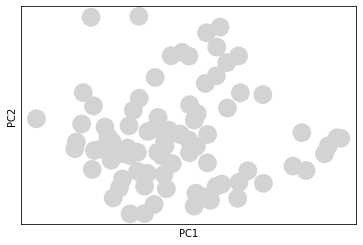

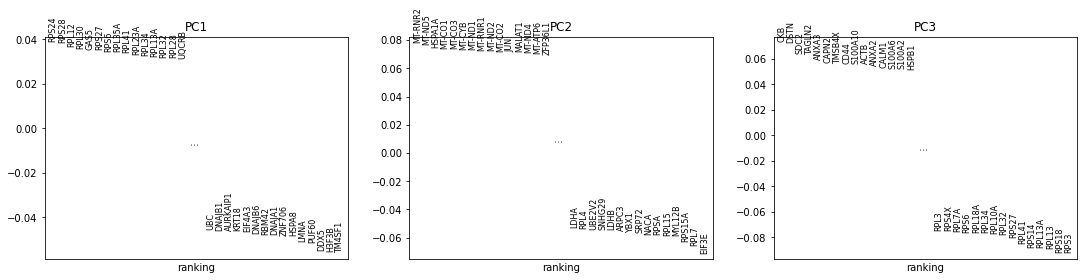

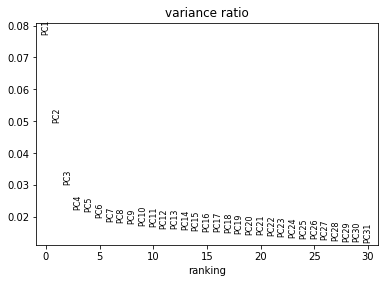

In [270]:
sc.tl.pca(adata_PDX2POOL_decontX_process, svd_solver='auto')
sc.pl.pca_overview(adata_PDX2POOL_decontX_process)

In [271]:
sc.pp.neighbors(adata_PDX2POOL_decontX_process, n_neighbors=20, n_pcs=25)
sc.tl.umap(adata_PDX2POOL_decontX_process)

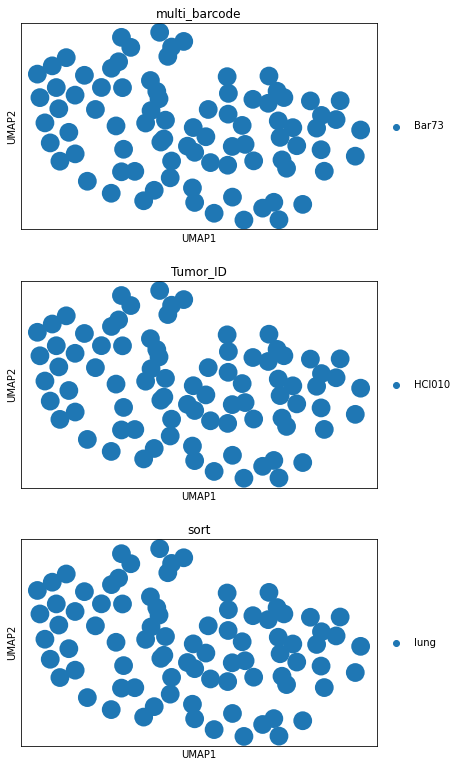

In [272]:
sc.pl.umap(adata_PDX2POOL_decontX_process, color=['multi_barcode','Tumor_ID','sort'],ncols=1)

In [273]:
# may taking only Bar 73 first

adata_PDX2POOL_decontX_process.obs.groupby('multi_barcode').apply(len)

multi_barcode
Bar73    85
dtype: int64

## Assignment

In [274]:
adata_PDX2POOL_decontX_process_final = adata_PDX2POOL_decontX_process.copy()

In [275]:
adata_PDX2POOL_decontX_process_final

AnnData object with n_obs × n_vars = 85 × 2838
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'sort_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [276]:
adata_PDX2POOL_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID','sort']).apply(len)

multi_barcode  Tumor_ID  sort
Bar73          HCI010    lung    85
dtype: int64

In [277]:
adata_PDX2POOL_decontX_process_final

AnnData object with n_obs × n_vars = 85 × 2838
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'sort_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [278]:
adata_PDX2POOL_decontX_process_final.obs['Tumor_ID_updated'] = adata_PDX2POOL_decontX_process_final.obs['Tumor_ID']
adata_PDX2POOL_decontX_process_final

AnnData object with n_obs × n_vars = 85 × 2838
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'Tumor_ID_updated'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'sort_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [279]:
adata_PDX2POOL_decontX_final_selected = adata_PDX2POOL_decontX[adata_PDX2POOL_decontX.obs.index.isin(adata_PDX2POOL_decontX_process_final.obs.index.tolist())].copy()
adata_PDX2POOL_decontX_final_selected

AnnData object with n_obs × n_vars = 85 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [280]:
adata_PDX2POOL_decontX_process_final

AnnData object with n_obs × n_vars = 85 × 2838
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'Tumor_ID_updated'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'sort_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [281]:
adata_PDX2POOL_decontX_final_selected.obs['n_counts'] = adata_PDX2POOL_decontX_process_final.obs['n_counts']
adata_PDX2POOL_decontX_final_selected.obs['n_genes'] = adata_PDX2POOL_decontX_process_final.obs['n_genes']
adata_PDX2POOL_decontX_final_selected.obs['percent_mito'] = adata_PDX2POOL_decontX_process_final.obs['percent_mito']
adata_PDX2POOL_decontX_final_selected.obs['multi_barcode'] = adata_PDX2POOL_decontX_process_final.obs['multi_barcode']
adata_PDX2POOL_decontX_final_selected.obs['Tumor_ID'] = adata_PDX2POOL_decontX_process_final.obs['Tumor_ID']
adata_PDX2POOL_decontX_final_selected.obs['Tumor_ID_updated'] = adata_PDX2POOL_decontX_process_final.obs['Tumor_ID_updated']
adata_PDX2POOL_decontX_final_selected.obs['run_id'] = 'PDX2POOL'
adata_PDX2POOL_decontX_final_selected.obs.index = [i.split('-')[0]+'-6' for i in adata_PDX2POOL_decontX_final_selected.obs.index]
adata_PDX2POOL_decontX_final_selected.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort,Tumor_ID_updated,run_id
AAAGATGTCAATCTCT-6,11822.826172,3565,4.902921,Bar73,HCI010,lung,HCI010,PDX2POOL
AACCATGCATATGCTG-6,2630.419434,437,0.702670,Bar73,HCI010,lung,HCI010,PDX2POOL
AACCGCGGTCGGCACT-6,4020.274414,1703,7.591985,Bar73,HCI010,lung,HCI010,PDX2POOL
AACTTTCCATGGTCTA-6,3501.821777,858,1.409626,Bar73,HCI010,lung,HCI010,PDX2POOL
AACTTTCGTTACAGAA-6,3770.156494,1712,17.726257,Bar73,HCI010,lung,HCI010,PDX2POOL
...,...,...,...,...,...,...,...,...
TGTATTCAGCAGGTCA-6,2753.905762,1102,1.610533,Bar73,HCI010,lung,HCI010,PDX2POOL
TGTGTTTTCAGTTTGG-6,3550.699707,812,1.172531,Bar73,HCI010,lung,HCI010,PDX2POOL
TTCGAAGGTAAGGGAA-6,3757.835205,1144,8.644559,Bar73,HCI010,lung,HCI010,PDX2POOL
TTCTCAAAGCAGCGTA-6,4937.593750,2285,9.750985,Bar73,HCI010,lung,HCI010,PDX2POOL


## PDX3A

In [282]:
adata_PDX3A_decontX = sc.read_csv('decontx_counts_output/decontX_PDX3A.csv')

In [283]:
adata_PDX3A_decontX = adata_PDX3A_decontX.T

In [284]:
adata_PDX3A_decontX

AnnData object with n_obs × n_vars = 5271 × 58870

In [285]:
sc.pp.filter_cells(adata_PDX3A_decontX, min_counts=0)
sc.pp.filter_cells(adata_PDX3A_decontX, min_genes=0)

In [286]:
mito_genes = adata_PDX3A_decontX.var_names.str.startswith('MT-')
adata_PDX3A_decontX.obs['percent_mito'] = np.sum(
    adata_PDX3A_decontX[:, mito_genes].X, axis=1) / np.sum(adata_PDX3A_decontX.X, axis=1) * 100


In [287]:
adata_PDX3A_decontX

AnnData object with n_obs × n_vars = 5271 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito'

In [288]:
temp_df = multi_result[multi_result['experiment'] == "PDX3_A"]
temp_df.index = [i.split('-')[0] + '-1' for i in temp_df.index]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGACACTAA-1,Bar15,Bar15,Bar15,PDX3_A
AAACCTGAGACATAAC-1,Bar7,Bar7,Bar7,PDX3_A
AAACCTGAGAGCCTAG-1,Bar14,Bar14,Bar14,PDX3_A
AAACCTGAGAGTTGGC-1,Negative,Negative,Bar4,PDX3_A
AAACCTGAGATACACA-1,Doublet,Doublet,Doublet,PDX3_A
...,...,...,...,...
TTTGTCATCCGCGTTT-1,Doublet,Doublet,Doublet,PDX3_A
TTTGTCATCGGTCTAA-1,Bar5,Bar5,Bar5,PDX3_A
TTTGTCATCGTGTAGT-1,Bar7,Bar7,Bar7,PDX3_A
TTTGTCATCTATGTGG-1,Bar13,Bar13,Bar13,PDX3_A


In [289]:
adata_PDX3A_decontX.obs.index = [i.split('.')[0]+'-1' for i in adata_PDX3A_decontX.obs.index]
adata_PDX3A_decontX.obs

,n_counts,n_genes,percent_mito
AAACCTGAGAGTTGGC-1,9644.559570,2101,15.605013
AAACCTGAGATACACA-1,18335.691406,4834,12.787426
AAACCTGAGGCCCTCA-1,28363.304688,3929,7.113503
AAACCTGCAACTGGCC-1,825.318420,961,20.539684
AAACCTGCAATCGAAA-1,9764.385742,3024,17.521328
...,...,...,...
TTTGTCACACAGAGGT-1,3238.972656,1599,13.351530
TTTGTCACAGACAAAT-1,2009.062622,1421,17.825342
TTTGTCACAGCCTTGG-1,18180.230469,3410,7.317849
TTTGTCAGTCTAGGTT-1,1124.344360,872,25.282612


In [290]:
temp_df = temp_df[temp_df.index.isin(adata_PDX3A_decontX.obs.index.tolist())]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGAGTTGGC-1,Negative,Negative,Bar4,PDX3_A
AAACCTGAGATACACA-1,Doublet,Doublet,Doublet,PDX3_A
AAACCTGAGGCCCTCA-1,Negative,Negative,Bar4,PDX3_A
AAACCTGCAACTGGCC-1,Negative,Bar4,Bar4,PDX3_A
AAACCTGCAATCGAAA-1,Negative,Negative,Negative,PDX3_A
...,...,...,...,...
TTTGTCACAAAGCAAT-1,Bar1,Bar1,Bar1,PDX3_A
TTTGTCACACAGAGGT-1,Negative,Negative,Bar1,PDX3_A
TTTGTCACAGACAAAT-1,Bar4,Bar4,Bar4,PDX3_A
TTTGTCACAGCCTTGG-1,Negative,Negative,Bar1,PDX3_A


In [291]:
adata_PDX3A_decontX.obs['multi_barcode'] = "Negative"
for i in temp_df.index:
    adata_PDX3A_decontX.obs.loc[i, 'multi_barcode'] = temp_df.loc[i, 'MULTI']

In [292]:
myList = list(set(adata_PDX3A_decontX.obs['multi_barcode']))

auxdict = dict(multi_barcodes_metadata['Tumor'][myList])
adata_PDX3A_decontX.obs['Tumor_ID'] = adata_PDX3A_decontX.obs['multi_barcode'].map(auxdict)
auxdict = dict(multi_barcodes_metadata['Tissue'][myList])
adata_PDX3A_decontX.obs['sort'] = adata_PDX3A_decontX.obs['multi_barcode'].map(auxdict)

In [293]:
adata_PDX3A_decontX.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort
AAACCTGAGAGTTGGC-1,9644.559570,2101,15.605013,Negative,Negative,Negative
AAACCTGAGATACACA-1,18335.691406,4834,12.787426,Doublet,Doublet,Doublet
AAACCTGAGGCCCTCA-1,28363.304688,3929,7.113503,Negative,Negative,Negative
AAACCTGCAACTGGCC-1,825.318420,961,20.539684,Negative,Negative,Negative
AAACCTGCAATCGAAA-1,9764.385742,3024,17.521328,Negative,Negative,Negative
...,...,...,...,...,...,...
TTTGTCACACAGAGGT-1,3238.972656,1599,13.351530,Negative,Negative,Negative
TTTGTCACAGACAAAT-1,2009.062622,1421,17.825342,Bar4,J53353,tumor
TTTGTCACAGCCTTGG-1,18180.230469,3410,7.317849,Negative,Negative,Negative
TTTGTCAGTCTAGGTT-1,1124.344360,872,25.282612,Bar5,J55454,tumor


## embedding

In [294]:
adata_PDX3A_decontX_process = adata_PDX3A_decontX.copy()

In [295]:
adata_PDX3A_decontX_process

AnnData object with n_obs × n_vars = 5271 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [296]:
adata_PDX3A_decontX_process = adata_PDX3A_decontX_process[~adata_PDX3A_decontX_process.obs['multi_barcode'].isin(['Doublet'])]
sc.pp.filter_cells(adata_PDX3A_decontX_process, min_counts=2500)
sc.pp.filter_cells(adata_PDX3A_decontX_process, min_genes=250)
adata_PDX3A_decontX_process = adata_PDX3A_decontX_process[adata_PDX3A_decontX_process.obs['percent_mito'] <= 50]
adata_PDX3A_decontX_process

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 4226 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [297]:
sc.pp.filter_genes(adata_PDX3A_decontX_process, min_cells=20)
sc.pp.highly_variable_genes(adata_PDX3A_decontX_process, n_top_genes=2000,flavor='seurat_v3')
sc.pp.normalize_per_cell(adata_PDX3A_decontX_process, counts_per_cell_after=1e4)
sc.pp.log1p(adata_PDX3A_decontX_process)

Trying to set attribute `.var` of view, copying.
/home/weilun/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.


In [298]:
adata_PDX3A_decontX_process

AnnData object with n_obs × n_vars = 4226 × 17325
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [299]:
adata_PDX1D_decontX_process.raw = adata_PDX3A_decontX_process
sc.tl.score_genes_cell_cycle(adata_PDX3A_decontX_process, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata_PDX3A_decontX_process, ['S_score', 'G2M_score'])
sc.pp.scale(adata_PDX3A_decontX_process,max_value=10)

... storing 'multi_barcode' as categorical
... storing 'Tumor_ID' as categorical
... storing 'sort' as categorical
... storing 'phase' as categorical


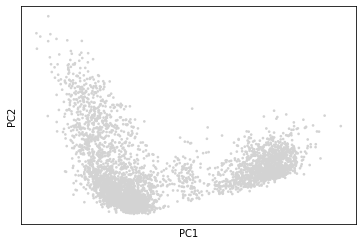

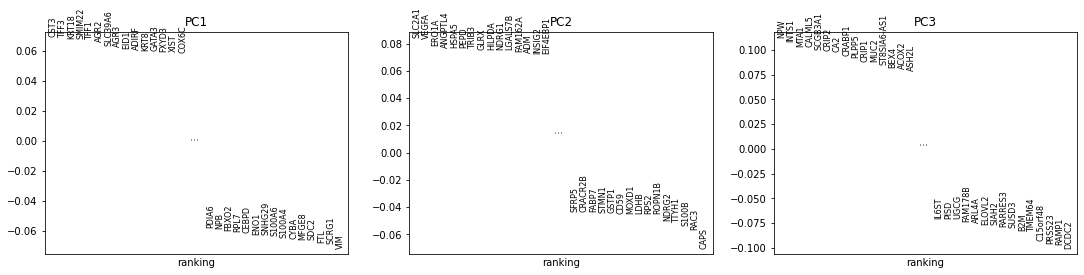

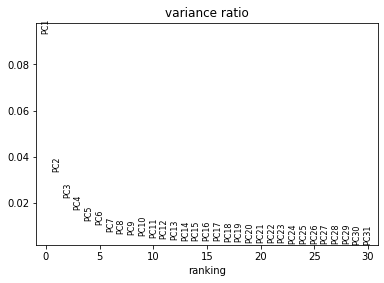

In [300]:
sc.tl.pca(adata_PDX3A_decontX_process, svd_solver='auto')
sc.pl.pca_overview(adata_PDX3A_decontX_process)

In [301]:
sc.pp.neighbors(adata_PDX3A_decontX_process, n_neighbors=20, n_pcs=15)
sc.tl.umap(adata_PDX3A_decontX_process)

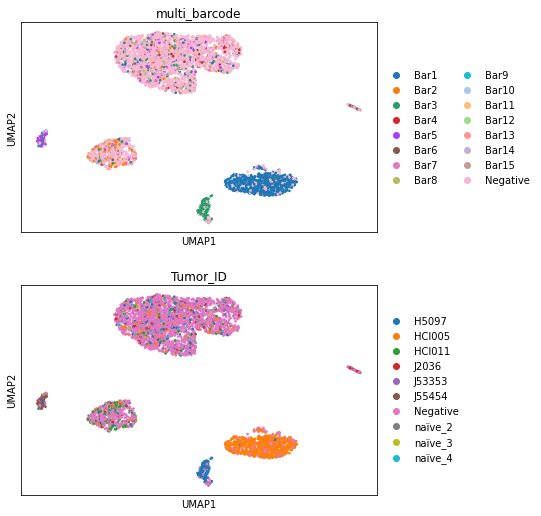

In [302]:
sc.pl.umap(adata_PDX3A_decontX_process, color=['multi_barcode','Tumor_ID'],ncols=1)

... storing 'dbscan_groups' as categorical


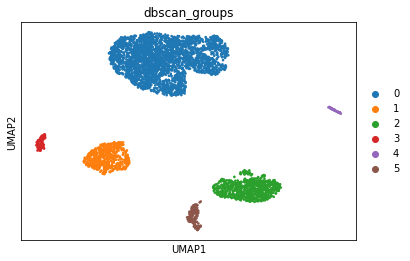

In [303]:
dbscan_umap(adata_PDX3A_decontX_process)
sc.pl.umap(adata_PDX3A_decontX_process, color=['dbscan_groups'],ncols=1)

In [304]:
adata_PDX3A_decontX_process.obs.groupby(['dbscan_groups','Tumor_ID']).apply(len)

dbscan_groups  Tumor_ID
0              H5097        121
               HCI005       100
               HCI011        54
               J2036         46
               J53353        48
               J55454        73
               Negative    2136
               naïve_2       83
               naïve_3       23
               naïve_4       74
1              H5097         18
               HCI005        21
               HCI011       106
               J2036          7
               J53353         2
               J55454        13
               Negative     330
               naïve_2        6
               naïve_3        3
               naïve_4        8
2              H5097          3
               HCI005       597
               J53353         1
               Negative     100
3              H5097          8
               HCI005         1
               HCI011         1
               J2036          1
               J55454        51
               Negative      19
               n

In [305]:
adata_PDX3A_decontX_process.obs.groupby(['Tumor_ID','sort']).apply(len)

Tumor_ID  sort    
H5097     lung           5
          tumor        248
HCI005    lung          61
          tumor        658
HCI011    lung          54
          tumor        108
J2036     lung           6
          tumor         59
J53353    lung          13
          tumor         38
J55454    lung           6
          tumor        131
Negative  Negative    2640
naïve_2   lung          90
naïve_3   lung          27
naïve_4   lung          82
dtype: int64

## Assignment

In [306]:
adata_PDX3A_decontX_process_final = adata_PDX3A_decontX_process.copy()

In [307]:
adata_PDX3A_decontX_process_final

AnnData object with n_obs × n_vars = 4226 × 17325
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'dbscan_groups_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [308]:
adata_PDX3A_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID','sort']).apply(len)

multi_barcode  Tumor_ID  sort    
Bar1           HCI005    tumor        658
Bar2           HCI011    tumor        108
Bar3           H5097     tumor        248
Bar4           J53353    tumor         38
Bar5           J55454    tumor        131
Bar6           J2036     tumor         59
Bar7           HCI005    lung          61
Bar8           HCI011    lung          54
Bar9           H5097     lung           5
Bar10          J53353    lung          13
Bar11          J55454    lung           6
Bar12          J2036     lung           6
Bar13          naïve_2   lung          90
Bar14          naïve_3   lung          27
Bar15          naïve_4   lung          82
Negative       Negative  Negative    2640
dtype: int64

In [309]:
adata_PDX3A_decontX_process_final.obs['Tumor_ID_updated'] = ""
for i in set(adata_PDX3A_decontX_process_final.obs['dbscan_groups']):
    temp_sub_adata = adata_PDX3A_decontX_process_final[adata_PDX3A_decontX_process_final.obs['dbscan_groups'] == i]
    temp_df = temp_sub_adata.obs.groupby(['Tumor_ID']).apply(len).to_frame()
    temp_df = temp_df.reset_index()
    temp_df = temp_df.set_index('Tumor_ID')
    temp_df = temp_df[~temp_df.index.isin(['Negative'])]
    adata_PDX3A_decontX_process_final.obs.loc[adata_PDX3A_decontX_process_final.obs['dbscan_groups'] == i, 'Tumor_ID_updated'] = temp_df[0].idxmax()

adata_PDX3A_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID_updated','sort']).apply(len)

multi_barcode  Tumor_ID_updated  sort    
Bar1           H5097             tumor         47
               HCI005            tumor        597
               HCI011            tumor         13
               J55454            tumor          1
Bar2           H5097             tumor         16
               HCI011            tumor         91
               J2036             tumor          1
Bar3           H5097             tumor        218
               HCI005            tumor          3
               HCI011            tumor         17
               J2036             tumor          2
               J55454            tumor          8
Bar4           H5097             tumor         38
Bar5           H5097             tumor         68
               HCI011            tumor         12
               J55454            tumor         51
Bar6           H5097             tumor         40
               HCI011            tumor          7
               J2036             tumor         11
        

... storing 'Tumor_ID_updated' as categorical


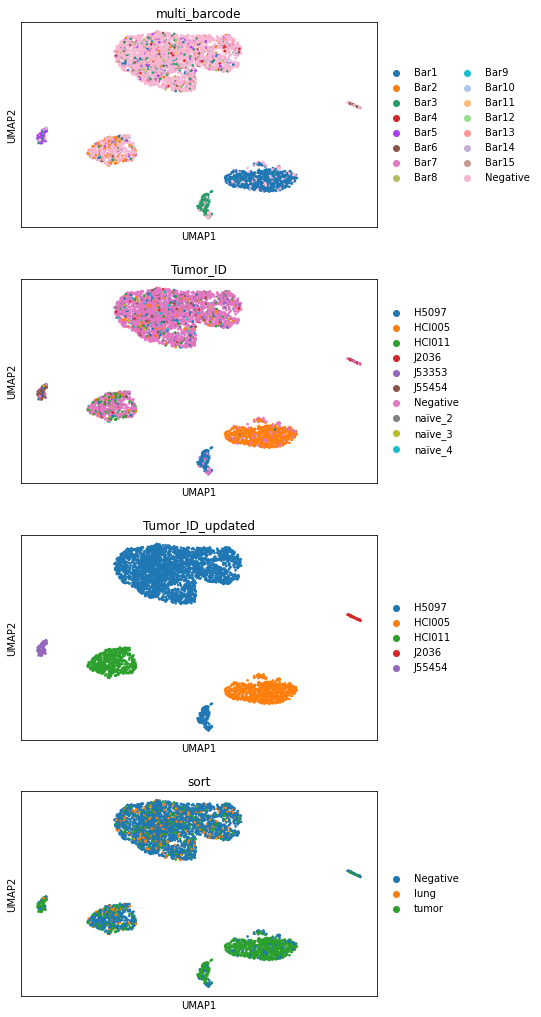

In [310]:
sc.pl.umap(adata_PDX3A_decontX_process_final, color=['multi_barcode','Tumor_ID','Tumor_ID_updated','sort'],ncols=1)

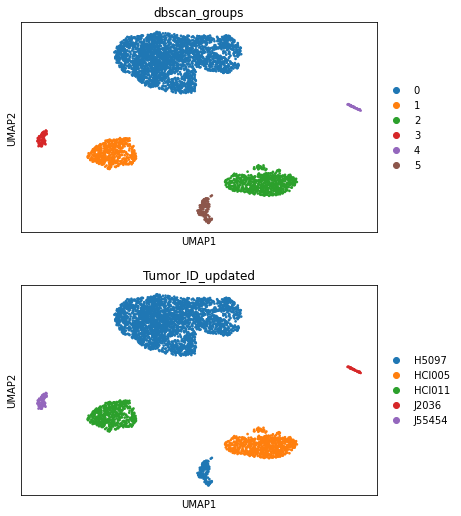

In [311]:
sc.pl.umap(adata_PDX3A_decontX_process_final, color=['dbscan_groups','Tumor_ID_updated'],ncols=1)

In [312]:
adata_PDX3A_decontX_process_final.obs['Tumor_ID_updated'] = adata_PDX3A_decontX_process_final.obs['Tumor_ID_updated'].astype('str')
adata_PDX3A_decontX_process_final.obs.loc[adata_PDX3A_decontX_process_final.obs['dbscan_groups'] == '0', 'Tumor_ID_updated'] = 'J53353'

... storing 'Tumor_ID_updated' as categorical


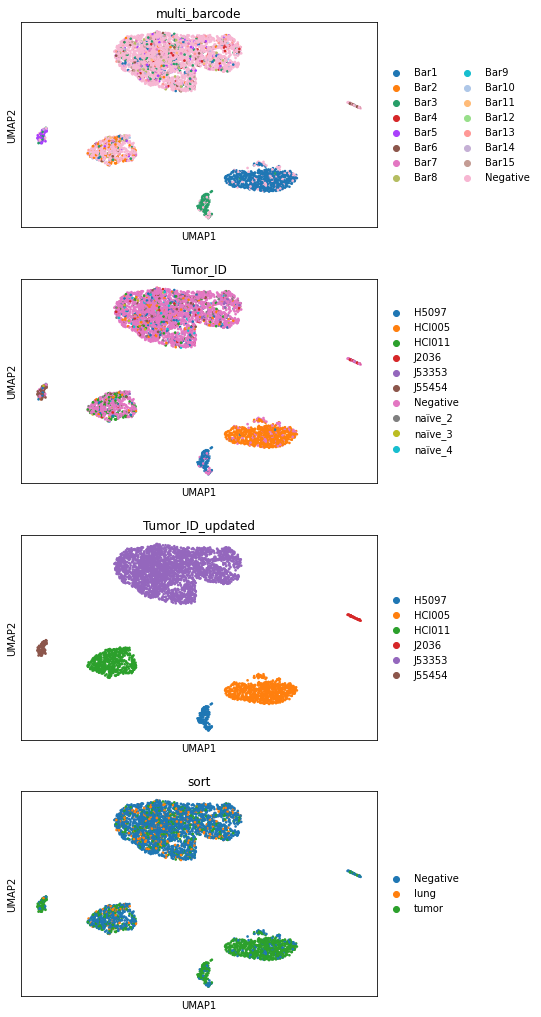

In [313]:
sc.pl.umap(adata_PDX3A_decontX_process_final, color=['multi_barcode','Tumor_ID','Tumor_ID_updated','sort'],ncols=1)

In [314]:
adata_PDX3A_decontX_final_selected = adata_PDX3A_decontX[adata_PDX3A_decontX.obs.index.isin(adata_PDX3A_decontX_process_final.obs.index.tolist())].copy()
adata_PDX3A_decontX_final_selected

AnnData object with n_obs × n_vars = 4226 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [315]:
adata_PDX3A_decontX_process_final

AnnData object with n_obs × n_vars = 4226 × 17325
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups', 'Tumor_ID_updated'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'dbscan_groups_colors', 'Tumor_ID_updated_colors', 'sort_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [316]:
adata_PDX3A_decontX_final_selected.obs['n_counts'] = adata_PDX3A_decontX_process_final.obs['n_counts']
adata_PDX3A_decontX_final_selected.obs['n_genes'] = adata_PDX3A_decontX_process_final.obs['n_genes']
adata_PDX3A_decontX_final_selected.obs['percent_mito'] = adata_PDX3A_decontX_process_final.obs['percent_mito']
adata_PDX3A_decontX_final_selected.obs['multi_barcode'] = adata_PDX3A_decontX_process_final.obs['multi_barcode']
adata_PDX3A_decontX_final_selected.obs['Tumor_ID'] = adata_PDX3A_decontX_process_final.obs['Tumor_ID']
adata_PDX3A_decontX_final_selected.obs['Tumor_ID_updated'] = adata_PDX3A_decontX_process_final.obs['Tumor_ID_updated']
adata_PDX3A_decontX_final_selected.obs['run_id'] = 'PDX3A'
adata_PDX3A_decontX_final_selected.obs.index = [i.split('-')[0]+'-7' for i in adata_PDX3A_decontX_final_selected.obs.index]
adata_PDX3A_decontX_final_selected.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort,Tumor_ID_updated,run_id
AAACCTGAGAGTTGGC-7,9639.329102,2101,15.605013,Negative,Negative,Negative,J53353,PDX3A
AAACCTGAGGCCCTCA-7,28350.800781,3929,7.113503,Negative,Negative,Negative,J53353,PDX3A
AAACCTGCAATCGAAA-7,9747.503906,3024,17.521328,Negative,Negative,Negative,HCI011,PDX3A
AAACCTGCACAAGTAA-7,6056.344727,1785,7.293991,Negative,Negative,Negative,J53353,PDX3A
AAACCTGCACATTTCT-7,35526.058594,5001,2.059683,Bar15,naïve_4,lung,J53353,PDX3A
...,...,...,...,...,...,...,...,...
TTTGTCAAGTGTCCCG-7,25629.371094,4172,3.594271,Negative,Negative,Negative,J53353,PDX3A
TTTGTCACAAAGCAAT-7,8690.613281,2652,9.132840,Bar1,HCI005,tumor,HCI005,PDX3A
TTTGTCACACAGAGGT-7,3236.574219,1599,13.351530,Negative,Negative,Negative,J53353,PDX3A
TTTGTCACAGCCTTGG-7,18170.662109,3410,7.317849,Negative,Negative,Negative,J53353,PDX3A


## PDX3B

In [317]:
adata_PDX3B_decontX = sc.read_csv('decontx_counts_output/decontX_PDX3B.csv')

In [318]:
adata_PDX3B_decontX = adata_PDX3B_decontX.T

In [319]:
adata_PDX3B_decontX

AnnData object with n_obs × n_vars = 5324 × 58870

In [320]:
sc.pp.filter_cells(adata_PDX3B_decontX, min_counts=0)
sc.pp.filter_cells(adata_PDX3B_decontX, min_genes=0)

In [321]:
mito_genes = adata_PDX3B_decontX.var_names.str.startswith('MT-')
adata_PDX3B_decontX.obs['percent_mito'] = np.sum(
    adata_PDX3B_decontX[:, mito_genes].X, axis=1) / np.sum(adata_PDX3B_decontX.X, axis=1) * 100


In [322]:
adata_PDX3B_decontX

AnnData object with n_obs × n_vars = 5324 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito'

In [323]:
temp_df = multi_result[multi_result['experiment'] == "PDX3_B"]
temp_df.index = [i.split('-')[0] + '-1' for i in temp_df.index]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGAGACGCACA-1,Bar5,Bar5,Bar5,PDX3_B
AAACCTGAGACTAGAT-1,Bar13,Bar13,Bar13,PDX3_B
AAACCTGAGGACTGGT-1,Doublet,Doublet,Doublet,PDX3_B
AAACCTGAGGCTCTTA-1,Negative,Bar6,Bar6,PDX3_B
AAACCTGAGGTACTCT-1,Bar7,Bar7,Bar7,PDX3_B
...,...,...,...,...
TTTGTCATCTACTATC-1,Bar1,Bar1,Bar1,PDX3_B
TTTGTCATCTGCTGCT-1,Bar15,Bar15,Bar15,PDX3_B
TTTGTCATCTGGGCCA-1,Negative,Negative,Bar10,PDX3_B
TTTGTCATCTGTCCGT-1,Bar7,Bar7,Bar7,PDX3_B


In [324]:
adata_PDX3B_decontX.obs.index = [i.split('.')[0]+'-1' for i in adata_PDX3B_decontX.obs.index]
adata_PDX3B_decontX.obs

,n_counts,n_genes,percent_mito
AAACCTGCACGTCTCT-1,12437.625000,2690,14.479117
AAACCTGCAGGACCCT-1,38775.859375,4283,7.838721
AAACCTGGTAGTGAAT-1,11425.315430,2338,3.776224
AAACCTGGTCGAATCT-1,25569.593750,4138,5.246559
AAACCTGGTTACAGAA-1,10937.678711,2399,12.007276
...,...,...,...
TTTGTCAGTGAGTGAC-1,15430.666016,2952,1.124316
TTTGTCAGTTCCAACA-1,19606.849609,3681,5.502220
TTTGTCAGTTCGTCTC-1,50368.609375,5625,4.933639
TTTGTCATCCTAGTGA-1,20200.496094,3937,1.519440


In [325]:
temp_df = temp_df[temp_df.index.isin(adata_PDX3B_decontX.obs.index.tolist())]
temp_df

,MULTI,MULTI_rescued,MULTI_rescued_all,experiment
AAACCTGCACGTCTCT-1,Negative,Bar7,Bar7,PDX3_B
AAACCTGCAGGACCCT-1,Negative,Negative,Bar4,PDX3_B
AAACCTGGTAGTGAAT-1,Negative,Negative,Bar4,PDX3_B
AAACCTGGTCGAATCT-1,Negative,Negative,Bar5,PDX3_B
AAACCTGGTTACAGAA-1,Negative,Negative,Bar4,PDX3_B
...,...,...,...,...
TTTGTCAGTGAGTGAC-1,Bar13,Bar13,Bar13,PDX3_B
TTTGTCAGTTCCAACA-1,Negative,Bar4,Bar4,PDX3_B
TTTGTCAGTTCGTCTC-1,Negative,Bar4,Bar4,PDX3_B
TTTGTCATCCTAGTGA-1,Negative,Negative,Bar15,PDX3_B


In [326]:
adata_PDX3B_decontX.obs['multi_barcode'] = "Negative"
for i in temp_df.index:
    adata_PDX3B_decontX.obs.loc[i, 'multi_barcode'] = temp_df.loc[i, 'MULTI']

In [327]:
myList = list(set(adata_PDX3B_decontX.obs['multi_barcode']))

auxdict = dict(multi_barcodes_metadata['Tumor'][myList])
adata_PDX3B_decontX.obs['Tumor_ID'] = adata_PDX3B_decontX.obs['multi_barcode'].map(auxdict)
auxdict = dict(multi_barcodes_metadata['Tissue'][myList])
adata_PDX3B_decontX.obs['sort'] = adata_PDX3B_decontX.obs['multi_barcode'].map(auxdict)

In [328]:
adata_PDX3B_decontX.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort
AAACCTGCACGTCTCT-1,12437.625000,2690,14.479117,Negative,Negative,Negative
AAACCTGCAGGACCCT-1,38775.859375,4283,7.838721,Negative,Negative,Negative
AAACCTGGTAGTGAAT-1,11425.315430,2338,3.776224,Negative,Negative,Negative
AAACCTGGTCGAATCT-1,25569.593750,4138,5.246559,Negative,Negative,Negative
AAACCTGGTTACAGAA-1,10937.678711,2399,12.007276,Negative,Negative,Negative
...,...,...,...,...,...,...
TTTGTCAGTGAGTGAC-1,15430.666016,2952,1.124316,Bar13,naïve_2,lung
TTTGTCAGTTCCAACA-1,19606.849609,3681,5.502220,Negative,Negative,Negative
TTTGTCAGTTCGTCTC-1,50368.609375,5625,4.933639,Negative,Negative,Negative
TTTGTCATCCTAGTGA-1,20200.496094,3937,1.519440,Negative,Negative,Negative


## embedding

In [329]:
adata_PDX3B_decontX_process = adata_PDX3B_decontX.copy()

In [330]:
adata_PDX3B_decontX_process

AnnData object with n_obs × n_vars = 5324 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [331]:
adata_PDX3B_decontX_process = adata_PDX3B_decontX_process[~adata_PDX3B_decontX_process.obs['multi_barcode'].isin(['Doublet'])]
sc.pp.filter_cells(adata_PDX3B_decontX_process, min_counts=2500)
sc.pp.filter_cells(adata_PDX3B_decontX_process, min_genes=250)
adata_PDX3B_decontX_process = adata_PDX3B_decontX_process[adata_PDX3B_decontX_process.obs['percent_mito'] <= 50]
adata_PDX3B_decontX_process

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 4099 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [332]:
sc.pp.filter_genes(adata_PDX3B_decontX_process, min_cells=20)
sc.pp.highly_variable_genes(adata_PDX3B_decontX_process, n_top_genes=2000,flavor='seurat_v3')
sc.pp.normalize_per_cell(adata_PDX3B_decontX_process, counts_per_cell_after=1e4)
sc.pp.log1p(adata_PDX3B_decontX_process)

Trying to set attribute `.var` of view, copying.
/home/weilun/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.


In [333]:
adata_PDX3B_decontX_process

AnnData object with n_obs × n_vars = 4099 × 16824
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [334]:
adata_PDX3B_decontX_process.raw = adata_PDX3B_decontX_process
sc.tl.score_genes_cell_cycle(adata_PDX3B_decontX_process, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata_PDX3B_decontX_process, ['S_score', 'G2M_score'])
sc.pp.scale(adata_PDX3B_decontX_process,max_value=10)

... storing 'multi_barcode' as categorical
... storing 'Tumor_ID' as categorical
... storing 'sort' as categorical
... storing 'phase' as categorical


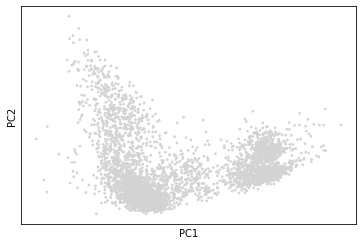

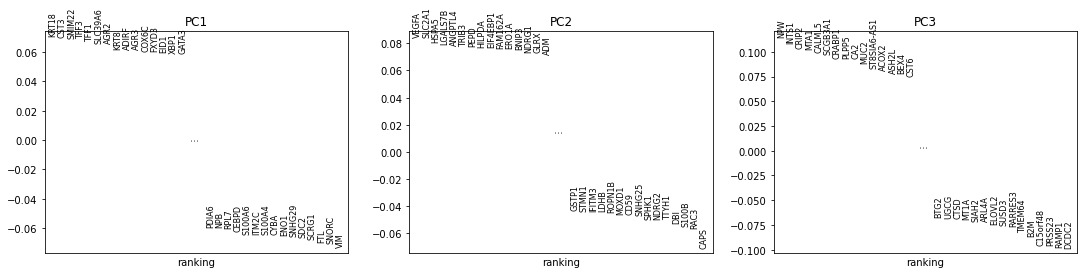

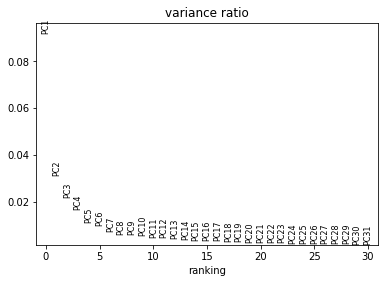

In [335]:
sc.tl.pca(adata_PDX3B_decontX_process, svd_solver='auto')
sc.pl.pca_overview(adata_PDX3B_decontX_process)

In [336]:
sc.pp.neighbors(adata_PDX3B_decontX_process, n_neighbors=20, n_pcs=15)
sc.tl.umap(adata_PDX3B_decontX_process)

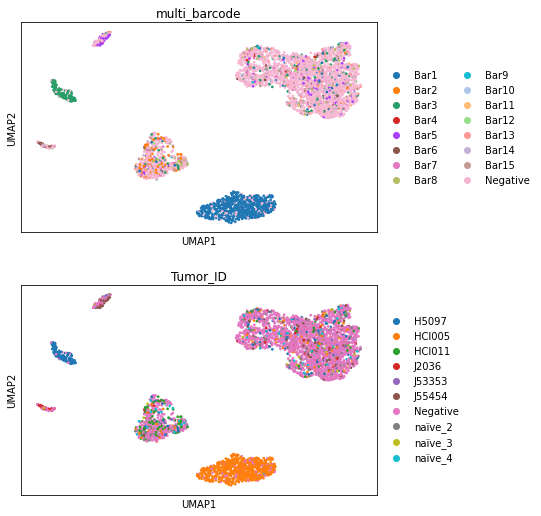

In [337]:
sc.pl.umap(adata_PDX3B_decontX_process, color=['multi_barcode','Tumor_ID'],ncols=1)

... storing 'dbscan_groups' as categorical


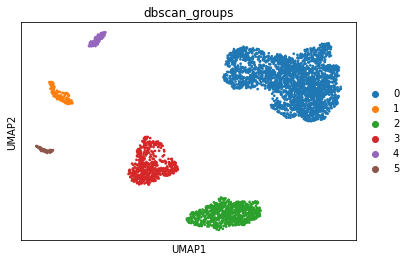

In [338]:
dbscan_umap(adata_PDX3B_decontX_process)
sc.pl.umap(adata_PDX3B_decontX_process, color=['dbscan_groups'],ncols=1)

In [339]:
adata_PDX3B_decontX_process.obs.groupby(['dbscan_groups','Tumor_ID']).apply(len)

dbscan_groups  Tumor_ID
0              H5097        108
               HCI005       126
               HCI011        63
               J2036         40
               J53353        25
               J55454       101
               Negative    1896
               naïve_2       84
               naïve_3       34
               naïve_4       54
1              H5097        116
               Negative      14
               naïve_4        1
2              HCI005       678
               Negative      64
               naïve_2        1
               naïve_4        1
3              H5097         27
               HCI005        30
               HCI011       111
               J2036          7
               J53353         2
               J55454        15
               Negative     319
               naïve_2       16
               naïve_3        5
               naïve_4       23
4              H5097          2
               HCI005         1
               HCI011         1
               J

In [340]:
adata_PDX3B_decontX_process.obs.groupby(['Tumor_ID','sort']).apply(len)

Tumor_ID  sort    
H5097     lung           6
          tumor        248
HCI005    lung          78
          tumor        757
HCI011    lung          73
          tumor        102
J2036     lung          12
          tumor         56
J53353    lung          11
          tumor         17
J55454    lung          20
          tumor        129
Negative  Negative    2365
naïve_2   lung         103
naïve_3   lung          41
naïve_4   lung          81
dtype: int64

## Assignment

In [341]:
adata_PDX3B_decontX_process_final = adata_PDX3B_decontX_process.copy()

In [342]:
adata_PDX3B_decontX_process_final

AnnData object with n_obs × n_vars = 4099 × 16824
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'dbscan_groups_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [343]:
adata_PDX3B_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID','sort']).apply(len)

multi_barcode  Tumor_ID  sort    
Bar1           HCI005    tumor        757
Bar2           HCI011    tumor        102
Bar3           H5097     tumor        248
Bar4           J53353    tumor         17
Bar5           J55454    tumor        129
Bar6           J2036     tumor         56
Bar7           HCI005    lung          78
Bar8           HCI011    lung          73
Bar9           H5097     lung           6
Bar10          J53353    lung          11
Bar11          J55454    lung          20
Bar12          J2036     lung          12
Bar13          naïve_2   lung         103
Bar14          naïve_3   lung          41
Bar15          naïve_4   lung          81
Negative       Negative  Negative    2365
dtype: int64

In [344]:
adata_PDX3B_decontX_process_final.obs['Tumor_ID_updated'] = ""
for i in set(adata_PDX3B_decontX_process_final.obs['dbscan_groups']):
    temp_sub_adata = adata_PDX3B_decontX_process_final[adata_PDX3B_decontX_process_final.obs['dbscan_groups'] == i]
    temp_df = temp_sub_adata.obs.groupby(['Tumor_ID']).apply(len).to_frame()
    temp_df = temp_df.reset_index()
    temp_df = temp_df.set_index('Tumor_ID')
    temp_df = temp_df[~temp_df.index.isin(['Negative'])]
    adata_PDX3B_decontX_process_final.obs.loc[adata_PDX3B_decontX_process_final.obs['dbscan_groups'] == i, 'Tumor_ID_updated'] = temp_df[0].idxmax()

adata_PDX3B_decontX_process_final.obs.groupby(['multi_barcode','Tumor_ID_updated','sort']).apply(len)

multi_barcode  Tumor_ID_updated  sort    
Bar1           HCI005            tumor        743
               HCI011            tumor         14
Bar2           HCI005            tumor         13
               HCI011            tumor         88
               J55454            tumor          1
Bar3           H5097             tumor        116
               HCI005            tumor        102
               HCI011            tumor         27
               J2036             tumor          1
               J55454            tumor          2
Bar4           HCI005            tumor         15
               HCI011            tumor          1
               J55454            tumor          1
Bar5           HCI005            tumor         84
               HCI011            tumor         12
               J55454            tumor         33
Bar6           HCI005            tumor         32
               HCI011            tumor          6
               J2036             tumor         17
        

... storing 'Tumor_ID_updated' as categorical


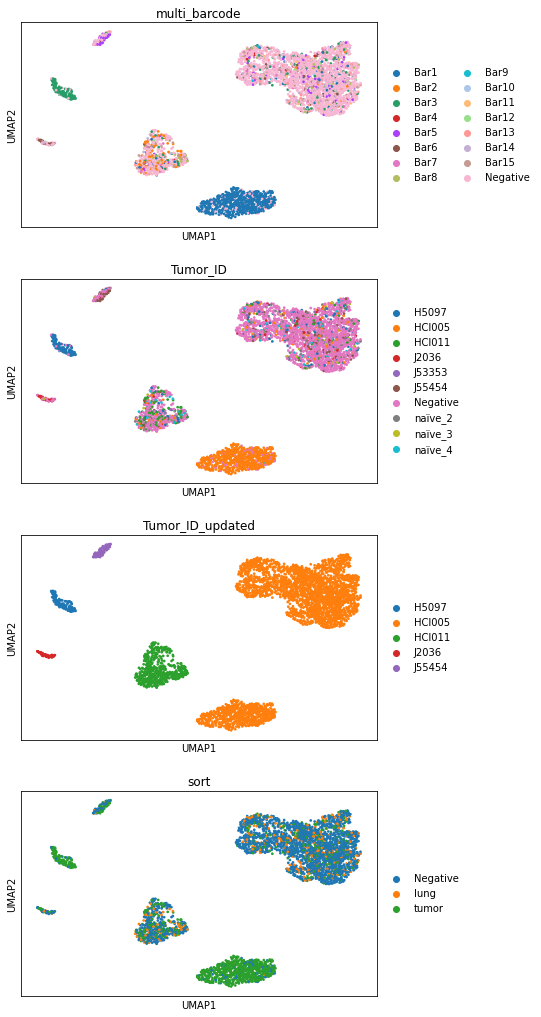

In [345]:
sc.pl.umap(adata_PDX3B_decontX_process_final, color=['multi_barcode','Tumor_ID','Tumor_ID_updated','sort'],ncols=1)

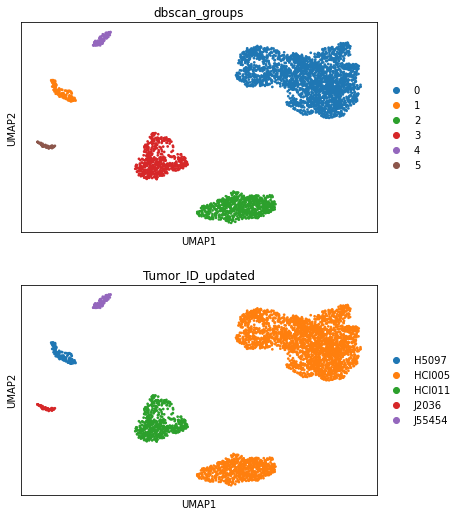

In [346]:
sc.pl.umap(adata_PDX3B_decontX_process_final, color=['dbscan_groups','Tumor_ID_updated'],ncols=1)

In [347]:
adata_PDX3B_decontX_process_final.obs.groupby(['dbscan_groups','Tumor_ID']).apply(len)

dbscan_groups  Tumor_ID
0              H5097        108
               HCI005       126
               HCI011        63
               J2036         40
               J53353        25
               J55454       101
               Negative    1896
               naïve_2       84
               naïve_3       34
               naïve_4       54
1              H5097        116
               Negative      14
               naïve_4        1
2              HCI005       678
               Negative      64
               naïve_2        1
               naïve_4        1
3              H5097         27
               HCI005        30
               HCI011       111
               J2036          7
               J53353         2
               J55454        15
               Negative     319
               naïve_2       16
               naïve_3        5
               naïve_4       23
4              H5097          2
               HCI005         1
               HCI011         1
               J

In [348]:
adata_PDX3B_decontX_process_final.obs['Tumor_ID_updated'] = adata_PDX3B_decontX_process_final.obs['Tumor_ID_updated'].astype('str')
adata_PDX3B_decontX_process_final.obs.loc[adata_PDX3B_decontX_process_final.obs['dbscan_groups'] == '0', 'Tumor_ID_updated'] = 'J53353'

... storing 'Tumor_ID_updated' as categorical


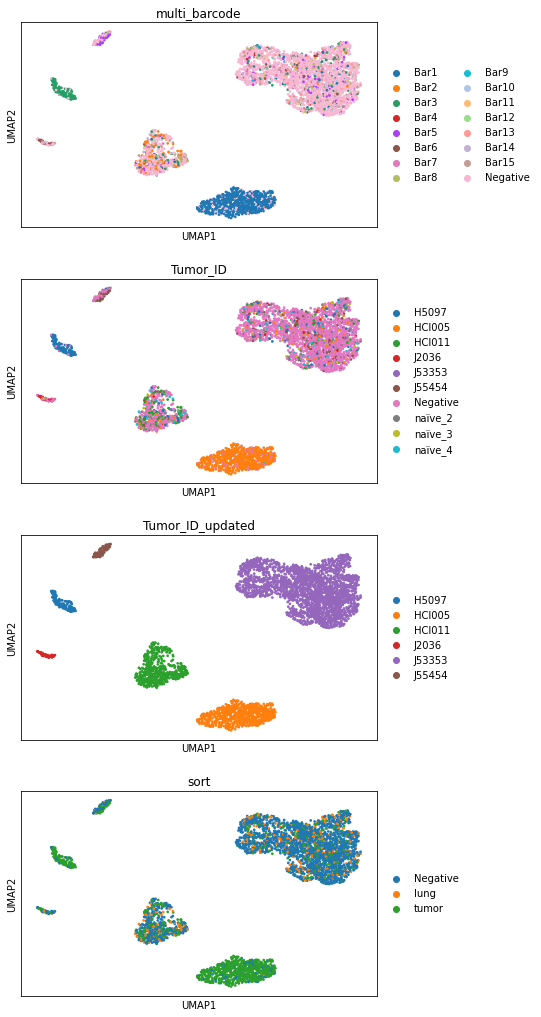

In [349]:
sc.pl.umap(adata_PDX3B_decontX_process_final, color=['multi_barcode','Tumor_ID','Tumor_ID_updated','sort'],ncols=1)

In [350]:
adata_PDX3B_decontX_final_selected = adata_PDX3B_decontX[adata_PDX3B_decontX.obs.index.isin(adata_PDX3B_decontX_process_final.obs.index.tolist())].copy()
adata_PDX3B_decontX_final_selected

AnnData object with n_obs × n_vars = 4099 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort'

In [351]:
adata_PDX3B_decontX_process_final

AnnData object with n_obs × n_vars = 4099 × 16824
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'S_score', 'G2M_score', 'phase', 'dbscan_groups', 'Tumor_ID_updated'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'multi_barcode_colors', 'Tumor_ID_colors', 'dbscan_groups_colors', 'Tumor_ID_updated_colors', 'sort_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [352]:
adata_PDX3B_decontX_final_selected.obs['n_counts'] = adata_PDX3B_decontX_process_final.obs['n_counts']
adata_PDX3B_decontX_final_selected.obs['n_genes'] = adata_PDX3B_decontX_process_final.obs['n_genes']
adata_PDX3B_decontX_final_selected.obs['percent_mito'] = adata_PDX3B_decontX_process_final.obs['percent_mito']
adata_PDX3B_decontX_final_selected.obs['multi_barcode'] = adata_PDX3B_decontX_process_final.obs['multi_barcode']
adata_PDX3B_decontX_final_selected.obs['Tumor_ID'] = adata_PDX3B_decontX_process_final.obs['Tumor_ID']
adata_PDX3B_decontX_final_selected.obs['Tumor_ID_updated'] = adata_PDX3B_decontX_process_final.obs['Tumor_ID_updated']
adata_PDX3B_decontX_final_selected.obs['run_id'] = 'PDX3B'
adata_PDX3B_decontX_final_selected.obs.index = [i.split('-')[0]+'-8' for i in adata_PDX3B_decontX_final_selected.obs.index]
adata_PDX3B_decontX_final_selected.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort,Tumor_ID_updated,run_id
AAACCTGCACGTCTCT-8,12430.142578,2690,14.479117,Negative,Negative,Negative,J53353,PDX3B
AAACCTGCAGGACCCT-8,38748.613281,4283,7.838721,Negative,Negative,Negative,J53353,PDX3B
AAACCTGGTAGTGAAT-8,11413.403320,2338,3.776224,Negative,Negative,Negative,J53353,PDX3B
AAACCTGGTCGAATCT-8,25548.167969,4138,5.246559,Negative,Negative,Negative,J53353,PDX3B
AAACCTGGTTACAGAA-8,10926.276367,2399,12.007276,Negative,Negative,Negative,J53353,PDX3B
...,...,...,...,...,...,...,...,...
TTTGTCAGTGAGTGAC-8,15408.063477,2952,1.124316,Bar13,naïve_2,lung,J53353,PDX3B
TTTGTCAGTTCCAACA-8,19585.318359,3681,5.502220,Negative,Negative,Negative,J53353,PDX3B
TTTGTCAGTTCGTCTC-8,50338.265625,5625,4.933639,Negative,Negative,Negative,J53353,PDX3B
TTTGTCATCCTAGTGA-8,20176.990234,3937,1.519440,Negative,Negative,Negative,J53353,PDX3B


# combining data

In [353]:
adata_final = adata_PDX1A_decontX_final_selected.concatenate([adata_PDX1B_decontX_final_selected, adata_PDX1C_decontX_final_selected, adata_PDX1D_decontX_final_selected,
                                                             adata_PDX2LT_decontX_final_selected, adata_PDX2POOL_decontX_final_selected,
                                                             adata_PDX3A_decontX_final_selected, adata_PDX3B_decontX_final_selected])

In [354]:
adata_final.obs

,n_counts,n_genes,percent_mito,multi_barcode,Tumor_ID,sort,Tumor_ID_updated,run_id,batch
AAACCTGAGCCACTAT-1-0,3061.061523,1204,28.874271,Sample4,H4272,tumor,H4272,PDX1A,0
AAACCTGTCCTTTCGG-1-0,8241.106445,3054,3.121930,Sample2,HCI001,tumor,HCI001,PDX1A,0
AAACCTGTCTTTACAC-1-0,5599.453613,2297,3.691891,Sample4,H4272,tumor,H4272,PDX1A,0
AAACGGGCACCACGTG-1-0,4058.026367,1175,26.499096,Sample4,H4272,tumor,H4272,PDX1A,0
AAACGGGCACCTCGTT-1-0,3332.828613,1231,14.729706,Sample2,HCI001,tumor,HCI001,PDX1A,0
...,...,...,...,...,...,...,...,...,...
TTTGTCAGTGAGTGAC-8-7,15408.063477,2952,1.124316,Bar13,naïve_2,lung,J53353,PDX3B,7
TTTGTCAGTTCCAACA-8-7,19585.318359,3681,5.502220,Negative,Negative,Negative,J53353,PDX3B,7
TTTGTCAGTTCGTCTC-8-7,50338.265625,5625,4.933639,Negative,Negative,Negative,J53353,PDX3B,7
TTTGTCATCCTAGTGA-8-7,20176.990234,3937,1.519440,Negative,Negative,Negative,J53353,PDX3B,7


In [355]:
adata_final.obs.groupby(['multi_barcode','Tumor_ID','sort']).apply(len)

multi_barcode  Tumor_ID  sort    
Bar1           HCI005    tumor       1415
Bar10          J53353    lung          24
Bar11          J55454    lung          26
Bar12          J2036     lung          18
Bar13          naïve_2   lung         193
Bar14          naïve_3   lung          68
Bar15          naïve_4   lung         163
Bar2           HCI011    tumor        210
Bar3           H5097     tumor        496
Bar4           J53353    tumor         55
Bar5           J55454    tumor        260
Bar6           J2036     tumor        115
Bar7           HCI005    lung         139
Bar73          HCI010    lung          85
Bar74          HCI010    tumor       1402
Bar8           HCI011    lung         127
Bar9           H5097     lung          11
Negative       Negative  Negative    6104
Sample1        HCI010    tumor         13
Sample10       HCI002    lung           3
Sample2        HCI001    tumor       2344
Sample3        HCI009    tumor          2
Sample4        H4272     tumor       3787


In [356]:
adata_final = adata_final[~adata_final.obs['multi_barcode'].isin(['Bar10', 'Bar11', 'Bar12', 'Bar7', 'Bar8', 'Bar9', 'Sample10',
                                                                 'Sample7','Sample8','Sample9'])]

In [357]:
adata_final

View of AnnData object with n_obs × n_vars = 17298 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'Tumor_ID', 'sort', 'Tumor_ID_updated', 'run_id', 'batch'

In [358]:
adata_final.obs.groupby(['multi_barcode','Tumor_ID','sort']).apply(len)

multi_barcode  Tumor_ID  sort    
Bar1           HCI005    tumor       1415
Bar13          naïve_2   lung         193
Bar14          naïve_3   lung          68
Bar15          naïve_4   lung         163
Bar2           HCI011    tumor        210
Bar3           H5097     tumor        496
Bar4           J53353    tumor         55
Bar5           J55454    tumor        260
Bar6           J2036     tumor        115
Bar73          HCI010    lung          85
Bar74          HCI010    tumor       1402
Negative       Negative  Negative    6104
Sample1        HCI010    tumor         13
Sample2        HCI001    tumor       2344
Sample3        HCI009    tumor          2
Sample4        H4272     tumor       3787
Sample5        HCI002    tumor        375
Sample6        HCI010    lung         211
dtype: int64

In [359]:
adata_final.obs.groupby(['Tumor_ID_updated','sort']).apply(len)

Tumor_ID_updated  sort    
H4272             Negative     253
                  lung           1
                  tumor       3787
H5097             Negative      42
                  lung           1
                  tumor        216
HCI001            Negative     713
                  lung           9
                  tumor       2375
HCI002            Negative      21
                  lung           2
                  tumor        350
HCI005            Negative     164
                  lung           2
                  tumor       1278
HCI010            Negative     112
                  lung         284
                  tumor       1411
HCI011            Negative     649
                  lung          61
                  tumor        288
J2036             Negative      60
                  lung           2
                  tumor         32
J53353            Negative    4032
                  lung         352
                  tumor        638
J55454            Negative  

In [360]:
cells_list = []
for i in adata_final.obs.index:
    if adata_final.obs.loc[i, 'Tumor_ID_updated'] != 'HCI010':
        if adata_final.obs.loc[i, 'sort'] == 'lung':
            cells_list.append(i)

In [361]:
len(cells_list)

436

In [362]:
adata_final = adata_final[~adata_final.obs.index.isin(cells_list)]
adata_final.obs.groupby(['Tumor_ID_updated','sort']).apply(len)

Tumor_ID_updated  sort    
H4272             Negative     253
                  tumor       3787
H5097             Negative      42
                  tumor        216
HCI001            Negative     713
                  tumor       2375
HCI002            Negative      21
                  tumor        350
HCI005            Negative     164
                  tumor       1278
HCI010            Negative     112
                  lung         284
                  tumor       1411
HCI011            Negative     649
                  tumor        288
J2036             Negative      60
                  tumor         32
J53353            Negative    4032
                  tumor        638
J55454            Negative      58
                  tumor         99
dtype: int64

In [363]:
adata_final.obs['sort_updated'] = adata_final.obs['sort']
for i in set(adata_final.obs['Tumor_ID_updated']):
    if i != 'HCI010':
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'sort_updated'] = 'tumor'
    else:
        adata_final.obs.loc[adata_final.obs['sort_updated'] == 'Negative', 'sort_updated'] = 'lung'

Trying to set attribute `.obs` of view, copying.


In [364]:
adata_final.obs.groupby(['Tumor_ID_updated','sort_updated']).apply(len)

Tumor_ID_updated  sort_updated
H4272             tumor           4040
H5097             tumor            258
HCI001            tumor           3088
HCI002            tumor            371
HCI005            tumor           1442
HCI010            lung             396
                  tumor           1411
HCI011            tumor            937
J2036             tumor             92
J53353            tumor           4670
J55454            tumor            157
dtype: int64

In [365]:
adata_final.obs['receptor_status'] = ''
adata_final.obs['ER_receptor'] = ''
for i in set(adata_final.obs['Tumor_ID_updated']):
    if i in ['HCI011', 'H5097', 'HCI005']:
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ER_receptor'] = 'ER+'
        if i in ['HCI005']:
            adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'receptor_status'] = 'ER+PR+Her2+'
        elif i in ['HCI011', 'H5097']:
            adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'receptor_status'] = 'ER+PR+'
    else:
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ER_receptor'] = 'ER-'
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'receptor_status'] = 'TNBC'

In [366]:
adata_final.obs.groupby(['ER_receptor','Tumor_ID_updated']).apply(len)

ER_receptor  Tumor_ID_updated
ER+          H5097                258
             HCI005              1442
             HCI011               937
ER-          H4272               4040
             HCI001              3088
             HCI002               371
             HCI010              1807
             J2036                 92
             J53353              4670
             J55454               157
dtype: int64

In [367]:
adata_final.obs.groupby(['receptor_status','Tumor_ID_updated']).apply(len)

receptor_status  Tumor_ID_updated
ER+PR+           H5097                258
                 HCI011               937
ER+PR+Her2+      HCI005              1442
TNBC             H4272               4040
                 HCI001              3088
                 HCI002               371
                 HCI010              1807
                 J2036                 92
                 J53353              4670
                 J55454               157
dtype: int64

In [368]:
adata_final.obs['intrinsic_BC_type'] = ''
for i in set(adata_final.obs['Tumor_ID_updated']):
    if i in ['HCI011', 'HCI009', 'HCI005']:
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'intrinsic_BC_type'] = 'luminal B'
    else:
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'intrinsic_BC_type'] = 'basal'

In [369]:
adata_final.obs.groupby(['intrinsic_BC_type','Tumor_ID_updated']).apply(len)

intrinsic_BC_type  Tumor_ID_updated
basal              H4272               4040
                   H5097                258
                   HCI001              3088
                   HCI002               371
                   HCI010              1807
                   J2036                 92
                   J53353              4670
                   J55454               157
luminal B          HCI005              1442
                   HCI011               937
dtype: int64

In [370]:
set(adata_final.obs['Tumor_ID_updated'])

{'H4272',
 'H5097',
 'HCI001',
 'HCI002',
 'HCI005',
 'HCI010',
 'HCI011',
 'J2036',
 'J53353',
 'J55454'}

In [371]:
adata_final.obs['ranking_ID'] = ''
for i in set(adata_final.obs['Tumor_ID_updated']):
    if i == 'HCI002':
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ranking_ID'] = '01_'+i 
    if i == 'J55454':
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ranking_ID'] = '02_'+i
    if i == 'HCI005':
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ranking_ID'] = '04_'+i
    if i == 'H4272':
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ranking_ID'] = '06_'+i 
    if i == 'HCI011':
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ranking_ID'] = '08_'+i 
    if i == 'HCI001':
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ranking_ID'] = '09_'+i 
    if i == 'H5097':
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ranking_ID'] = '10_'+i 
    if i == 'J2036':
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ranking_ID'] = '11_'+i 
    if i == 'J53353':
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ranking_ID'] = '12_'+i 
    if i == 'HCI010':
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'ranking_ID'] = '13_'+i 

In [372]:
adata_final.obs['metastatic_potential_rank'] = [x.split('_')[0] for x in adata_final.obs['ranking_ID']]

In [373]:
for i in set(adata_final.obs['Tumor_ID_updated']):
    if i in ['H4272','HCI002','HCI005','J55454']:
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'metastatic_potential_group'] = 'low'
    if i in ['HCI001','HCI011']:
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'metastatic_potential_group'] = 'moderate'
    if i in ['H5097','HCI010','J2036','J53353']:
        adata_final.obs.loc[adata_final.obs['Tumor_ID_updated'] == i, 'metastatic_potential_group'] = 'high'

In [374]:
adata_final.obs = adata_final.obs.rename(columns={"Tumor_ID": "multi_tumor_ID","sort": "multi_sort",
                                                 "Tumor_ID_updated": "Tumor_ID","sort_updated": "sort"})

In [375]:
adata_PDX1A.obs.index = [i.split('-')[0]+'-1' for i in adata_PDX1A.obs.index]
adata_PDX1B.obs.index = [i.split('-')[0]+'-2' for i in adata_PDX1B.obs.index]
adata_PDX1C.obs.index = [i.split('-')[0]+'-3' for i in adata_PDX1C.obs.index]
adata_PDX1D.obs.index = [i.split('-')[0]+'-4' for i in adata_PDX1D.obs.index]
adata_PDX2LT.obs.index = [i.split('-')[0]+'-5' for i in adata_PDX2LT.obs.index]
adata_PDX2POOL.obs.index = [i.split('-')[0]+'-6' for i in adata_PDX2POOL.obs.index]
adata_PDX3A.obs.index = [i.split('-')[0]+'-7' for i in adata_PDX3A.obs.index]
adata_PDX3B.obs.index = [i.split('-')[0]+'-8' for i in adata_PDX3B.obs.index]

In [376]:
adata_raw = adata_PDX1A.concatenate([adata_PDX1B, adata_PDX1C, adata_PDX1D,adata_PDX2LT, adata_PDX2POOL, adata_PDX3A, adata_PDX3B])
adata_raw

AnnData object with n_obs × n_vars = 30762 × 58870
    obs: 'run_id', 'n_counts', 'n_genes', 'percent_mito', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [377]:
adata_raw.obs

,run_id,n_counts,n_genes,percent_mito,batch
AAACCTGAGCCACTAT-1-0,PDX1A,3417.0,1204,29.382500,0
AAACCTGTCCTTTCGG-1-0,PDX1A,11874.0,3054,2.897086,0
AAACCTGTCTTTACAC-1-0,PDX1A,7474.0,2297,3.759700,0
AAACGGGCACCACGTG-1-0,PDX1A,4297.0,1175,26.762858,0
AAACGGGCACCTCGTT-1-0,PDX1A,4203.0,1231,14.061385,0
...,...,...,...,...,...
TTTGTCAGTGAGTGAC-8-7,PDX3B,15582.0,2952,1.135926,7
TTTGTCAGTTCCAACA-8-7,PDX3B,20085.0,3681,5.665920,7
TTTGTCAGTTCGTCTC-8-7,PDX3B,50776.0,5625,4.982669,7
TTTGTCATCCTAGTGA-8-7,PDX3B,20744.0,3937,1.576359,7


In [378]:
adata_raw = adata_raw[adata_raw.obs.index.isin(adata_final.obs.index)]
adata_raw

View of AnnData object with n_obs × n_vars = 16862 × 58870
    obs: 'run_id', 'n_counts', 'n_genes', 'percent_mito', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

In [379]:
adata_final

AnnData object with n_obs × n_vars = 16862 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'multi_tumor_ID', 'multi_sort', 'Tumor_ID', 'run_id', 'batch', 'sort', 'receptor_status', 'ER_receptor', 'intrinsic_BC_type', 'ranking_ID', 'metastatic_potential_rank', 'metastatic_potential_group'

In [380]:
adata_final.layers['raw_counts'] = adata_raw.X
adata_final.layers['decontX_counts'] = adata_final.X
adata_final

AnnData object with n_obs × n_vars = 16862 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'multi_barcode', 'multi_tumor_ID', 'multi_sort', 'Tumor_ID', 'run_id', 'batch', 'sort', 'receptor_status', 'ER_receptor', 'intrinsic_BC_type', 'ranking_ID', 'metastatic_potential_rank', 'metastatic_potential_group'
    layers: 'raw_counts', 'decontX_counts'

In [381]:
set(adata_final.obs['sort'])

{'lung', 'tumor'}

In [382]:
adata_final.obs['sort'] = adata_final.obs['sort'].replace(['tumor'],'Tumor')
adata_final.obs['sort'] = adata_final.obs['sort'].replace(['lung'],'Metastatic')

In [383]:
set(adata_final.obs['sort'])

{'Metastatic', 'Tumor'}

In [384]:
adata_final.obs = adata_final.obs.rename(columns={"multi_barcode": "MULTI_barcode", "multi_tumor_ID": "MULTI_tumor_ID", "multi_sort": "MULTI_sort"})
adata_final

AnnData object with n_obs × n_vars = 16862 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'MULTI_barcode', 'MULTI_tumor_ID', 'MULTI_sort', 'Tumor_ID', 'run_id', 'batch', 'sort', 'receptor_status', 'ER_receptor', 'intrinsic_BC_type', 'ranking_ID', 'metastatic_potential_rank', 'metastatic_potential_group'
    layers: 'raw_counts', 'decontX_counts'

In [385]:
adata_final.obs = adata_final.obs.rename(columns={"batch": "sequencing_batch"})
adata_final

AnnData object with n_obs × n_vars = 16862 × 58870
    obs: 'n_counts', 'n_genes', 'percent_mito', 'MULTI_barcode', 'MULTI_tumor_ID', 'MULTI_sort', 'Tumor_ID', 'run_id', 'sequencing_batch', 'sort', 'receptor_status', 'ER_receptor', 'intrinsic_BC_type', 'ranking_ID', 'metastatic_potential_rank', 'metastatic_potential_group'
    layers: 'raw_counts', 'decontX_counts'

In [386]:
set(adata_final.obs['run_id'])

{'PDX1A', 'PDX1B', 'PDX1C', 'PDX1D', 'PDX2LT', 'PDX2POOL', 'PDX3A', 'PDX3B'}

In [387]:
for i in set(adata_final.obs['run_id']):
    if i in ['PDX1A', 'PDX1B', 'PDX1C', 'PDX1D']:
        adata_final.obs.loc[adata_final.obs['run_id'] == i, 'sequencing_batch'] = '1'
    elif i in ['PDX2LT', 'PDX2POOL']:
        adata_final.obs.loc[adata_final.obs['run_id'] == i, 'sequencing_batch'] = '2'
    elif i in ['PDX3A', 'PDX3B']:
        adata_final.obs.loc[adata_final.obs['run_id'] == i, 'sequencing_batch'] = '3'

In [388]:
set(adata_final.obs['sequencing_batch'])

{'1', '2', '3'}

In [389]:
adata_final.write('MULTI_decontX_raw.h5ad')

... storing 'MULTI_barcode' as categorical
... storing 'MULTI_tumor_ID' as categorical
... storing 'MULTI_sort' as categorical
... storing 'Tumor_ID' as categorical
... storing 'run_id' as categorical
... storing 'sort' as categorical
... storing 'receptor_status' as categorical
... storing 'ER_receptor' as categorical
... storing 'intrinsic_BC_type' as categorical
... storing 'ranking_ID' as categorical
... storing 'metastatic_potential_rank' as categorical
... storing 'metastatic_potential_group' as categorical
